## **INTRODUCTION**
### **OBJECTIF**  
Construire un système de suggestion de tags associés aux questions envoyées sur la plateforme StackOverFlow

Stack Overflow est l’une des plus grandes plateformes communautaires d’entraide pour les développeurs. Chaque jour, des milliers de questions y sont posées, accompagnées de tags qui permettent de catégoriser les sujets abordés (langages, frameworks, outils, concepts, etc.).

L’objectif de ce projet est de concevoir un système capable de **suggérer automatiquement des tags pertinents** à partir du texte d’une question (titre et corps).  
Ce système pourra aider les utilisateurs à mieux annoter leurs questions, améliorer la recherche d’information, et faciliter la modération.

Pour cela, nous allons suivre une démarche complète de traitement du langage naturel (NLP) en plusieurs étapes :

1. **Chargement et nettoyage des données** issues d’une extraction SQL sur Stack Exchange Data Explorer
2. **Exploration du corpus** pour comprendre la structure des textes et des tags
3. **Vectorisation des textes** à l’aide de méthodes comme TF-IDF ou des embeddings
4. **Encodage des tags** pour la classification multi-label
5. **Modélisation supervisée et non supervisée** pour prédire ou regrouper les questions
6. **Évaluation des performances** et préparation au déploiement

Dans un souci de rigueur et d’efficacité, toutes les étapes sont d’abord testées sur un échantillon réduit de 100 questions, avant d’être généralisées à l’ensemble du corpus.

Ce notebook documente l’ensemble de cette démarche, étape par étape.



### **APPROCHE**  
Afin de garantir un développement progressif, rapide et contrôlé du pipeline NLP, nous adoptons une stratégie en deux temps :  
1. D'abord l'expérimentation sur un échantillon réduit (`sample_df`)  
2. Puis la mise à l’échelle sur l’ensemble du corpus (`brut_df`)  

Le tableau ci-dessous résume les étapes concernées par chaque phase :  


| Étape                         | Sur `sample_df` ? | Sur `brut_df` ? |
|------------------------------|-------------------|-----------------|
| Nettoyage                    | ✅ Oui            | ✅ Ensuite       |
| EDA (section 3)              | ✅ Oui            | ❌ Pas nécessaire |
| Feature engineering (section 4) | ✅ Oui         | ✅ Ensuite       |
| Modélisation                 | ❌ Non            | ✅ Oui           |


## **IMPORTS**

In [ ]:
import os
print(f"# --- VERIFICATION DU REPERTOIRE COURANT : {os.getcwd()}")
import pandas as pd
import spacy
import re
import sys
sys.path.append("../src")  # pour que Python trouve le dossier src/
import seaborn as sns
import matplotlib.pyplot as plt
from preprocessing import text_cleaning
from tqdm.notebook import tqdm
from utils.tech_terms import load_tech_terms
from eda.eda_analysis import plot_distribution
from collections import Counter
from scipy.stats import entropy
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
print(load_tech_terms())

from api.client.embedding_client import get_embedding
from sklearn.preprocessing import MultiLabelBinarizer
import joblib
import ast


# --- VERIFICATION DU REPERTOIRE COURANT : d:\machine_learning_training\openclassrooms_projects\05_categorisez_automatiquement_question\notebooks
{'tensorflow', 'scikit-learn', 'pandas', 'node.js', 'mvc 3', 'c++', 'react.js', 'c#', 'asp.net'}


## **1. RECUPERATION DES DONNEES**
**Étapes de récupération à suivre :**
- [x] Charger au format fichier csv les données retournée par une requête T-SQL sur Stack Exchange Data Explorer  
- [x] Charger les données dans un dataframe  

### **1.1. EXTRACTION DES DONNEES VIA STACK EXCHANGE DATA EXPLORER**
La requête T-SQL saisie dans l'interface de SEDE est structurée de la façon suivante :

```sql
WITH Questions AS (
    SELECT
        p.Id AS PostId,
        p.Title,
        p.Body,
        p.Score,
        p.ViewCount,
        p.AnswerCount,
        p.CreationDate
    FROM Posts p
    WHERE p.PostTypeId = 1
      AND p.Score > 2
      AND p.ViewCount > 1000
      AND p.AnswerCount > 0
      AND p.Body IS NOT NULL
    ORDER BY p.Score DESC
    OFFSET 0 ROWS FETCH NEXT 500000 ROWS ONLY
),
TagsPerPost AS (
    SELECT
        pt.PostId,
        STRING_AGG(t.TagName, ';') AS Tags,
        COUNT(*) AS TagCount
    FROM PostTags pt
    JOIN Tags t ON pt.TagId = t.Id
    GROUP BY pt.PostId
)
SELECT
    q.PostId,
    q.Title,
    q.Body,
    q.Score,
    q.ViewCount,
    q.AnswerCount,
    q.CreationDate,
    t.TagCount,
    t.Tags
FROM Questions q
JOIN TagsPerPost t ON q.PostId = t.PostId
WHERE t.TagCount >= 5



| Critère                | Inclus ? | Commentaire                               |
|------------------------|----------|-------------------------------------------|
| Les plus vues          | ✅        | `ViewCount > 1000`                         |
| Jugées pertinentes     | ✅        | `Score > 2`                                |
| Mises en favori        | ❌        | Pas inclus, mais compensé par le score     |
| Ayant reçu une réponse | ✅        | `AnswerCount > 0`                          |
| ≥ 5 tags               | ✅        | `TagCount >= 5`                            |
| 50 000 lignes          | ✅        | `TOP 50000` + export réussi                |


**Le score d’une question Stack Overflow**  

Le **Score** d’une question = nombre de votes positifs – votes négatifs  
Il reflète la **pertinence perçue par la communauté**.

Voici comment interpréter les scores :

- `0` → question ignorée ou neutre  
- `1–2` → question correcte mais peu visible  
- `3–10` → question utile  
- `10+` → question très appréciée  
- `100+` → question culte


### **1.2. CHARGEMENT DES DONNEES DANS UN DATAFRAME**

In [3]:
# ---------------------------
# --- CHARGER LE FICHIER CSV
# ---------------------------
brut_df = pd.read_csv("../data/raw/stackoverflow_questions_sede.csv")
# -----------------------------------------------
# --- VERIFIER LE NOMBRE DE LIGNES ET UN APERCU
# -----------------------------------------------
print(f"Nombre de questions : {len(brut_df)}")
brut_df.head()

Nombre de questions : 50000


,PostId,Title,Body,Score,ViewCount,AnswerCount,CreationDate,TagCount,Tags
0,19,What is the fastest way to get the value of π?,<p>I'm looking for the fastest way to obtain t...,356,73332,23,2008-08-01 05:21:22,5,language-agnostic;unix;algorithm;performance;pi
1,594,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...,55,61757,3,2008-08-03 01:15:08,5,python;sql;database;cx-oracle;oracle-database
2,696,Connect PHP to IBM i (AS/400),<p>I've got an upcoming project wherein I will...,37,9502,9,2008-08-03 14:03:28,5,php;database;db2;odbc;ibm-midrange
3,855,.Net XML comment into API Documentation,<p>Is there an easy way to produce MSDN-style ...,21,3526,6,2008-08-03 22:03:37,5,documentation;xslt;sandcastle;xml-comments;vis...
4,1898,Import CSV file to strongly typed data structu...,<p>What's the best way to import a CSV file in...,108,71126,11,2008-08-05 04:43:22,5,c#;vb.net;csv;import;file


## **2. NETTOYAGE DES DONNEES**

**Objectif : transformer du texte brut en texte propre et exploitable**

**Les étapes de nettoyage à appliquer :**  

1. Suppression des balises HTML

2. Passage en minuscules

3. Suppression de la ponctuation, des chiffres, des caractères spéciaux

4. Tokenisation

5. Lemmatisation

6. Suppression des stopwords

7. Création de colonnes clean_title, clean_body

***Pourquoi travailler d'abord sur un échantillon de 100 questions ?***

Avant d'appliquer un pipeline NLP complet sur un jeu de données massif (ici 50 000 questions Stack Overflow),  
> **Il est judicieux de travailler d'abord sur un petit échantillon (ex : 100 questions).** 

Cette approche présente ces avantages :

| Avantage | Pourquoi c’est utile |
|----------|----------------------|
| 💨 Rapidité | Permet de tester et corriger rapidement sans attendre de longs temps de traitement |
| 🧪 Débogage facile | Facilite l'observation des erreurs ou effets inattendus dans les fonctions de nettoyage |
| 📊 Visualisation claire | Les graphiques et tableaux sont plus lisibles sur un petit corpus |
| 🧱 Modularité | Permet de construire des fonctions réutilisables et testées |
| 🧠 Compréhension | Aide à observer les effets du nettoyage, de la fréquence, etc. mot par mot |

Une fois que le pipeline est validé sur l’échantillon, 
> **on peut le mettre à l’échelle sur l’ensemble du jeu de données (`brut_df`) en appliquant les mêmes fonctions.**


### **2.1. APPLICATION SUR UN ECHANTILLON DE 100 QUESTIONS**

In [4]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES DE NETTOYAGES
# -------------------------------------------
import importlib
import preprocessing.text_cleaning as tc
importlib.reload(tc)

# --------------------------------------------------
# --- ON CONSTRUIT UN ECHANTILLON DE 100 QUESTIONS
# --------------------------------------------------
sample_df = brut_df.sample(100, random_state=42).copy()
# ----------------------------------------
# --- NETTOYAGE DES CORPUS TITLE ET BODY
# ----------------------------------------
sample_clean = sample_df.copy()
tqdm.pandas()
sample_clean["clean_title"] = sample_clean["Title"].progress_apply(tc.clean_text_spacy_custom)
sample_clean["clean_body"] = sample_clean["Body"].progress_apply(tc.clean_text_spacy_custom)

# --- APERCU DU RESULTAT
sample_clean[["Title", "clean_title", "Body", "clean_body"]].head(3)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

,Title,clean_title,Body,clean_body
33553,Why are Haskell Maps implemented as balanced b...,haskell maps implement balanced binary tree in...,"<p>From my limited knowledge of Haskell, it se...",limited knowledge haskell maps data map suppos...
9427,Measuring the average thickness of traces in a...,measure average thickness trace image,<p>Here's the problem: I have a number of bina...,problem number binary image compose trace diff...
199,How to create a dynamic LINQ join extension me...,create dynamic linq join extension method,"<p>There was a library of dynamic <a href=""htt...",library dynamic linq extension method release ...


## **3. EXPLORATION**

**Objectif : comprendre la structure du texte et du vocabulaire**  

L’objectif de cette section est d’explorer le contenu textuel des questions Stack Overflow afin de mieux comprendre la structure du corpus, la richesse du vocabulaire, la distribution des tags et les éventuelles anomalies.  
Cette phase exploratoire est essentielle pour guider les choix de nettoyage, de vectorisation et de modélisation.  
Toutes les analyses sont menées sur un échantillon réduit de 100 questions (`sample_df`) afin de faciliter l’expérimentation et la visualisation.




**Les étapes d'exploration à appliquer :**  
1. Fréquences de mots  
2. Nuages de mots  
3. Longueur des documents  
4. Distribution des tags  
5. Co-occurrence de mots ou de tags

### **3.1. APPLICATION SUR UN ECHANTILLON DE 100 QUESTIONS**

***--- PRÉPARATION DE LA PHASE D’EXPLORATION***  
On part du DataFrame nettoyé obtenu à l’issue de la phase de prétraitement.  
Pour éviter toute modification accidentelle, on travaille sur une copie :  
> df_explo = sample_df.copy()  

Cette copie sera utilisée dans toutes les étapes d’analyse exploratoire :  
- visualisation des distributions  
- détection des doublons et outliers  
- analyse des tags  
- etc.  

#### **3.1.1. FREQUENCE DES MOTS**

,word,frequency
0,create,7
1,class,6
2,method,4
3,object,4
4,cursor,4
...,...,...
95,trace,1
96,linq,1
97,join,1
98,extension,1


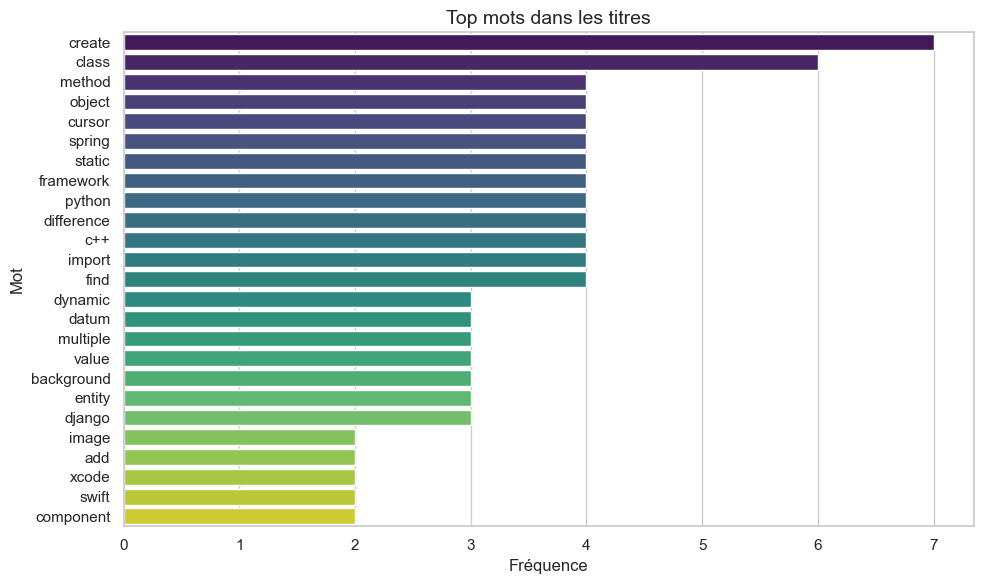

,word,frequency
0,time,69
1,like,58
2,class,57
3,write,51
4,work,51
...,...,...
95,content,12
96,nil,12
97,completion,12
98,nsdata,12


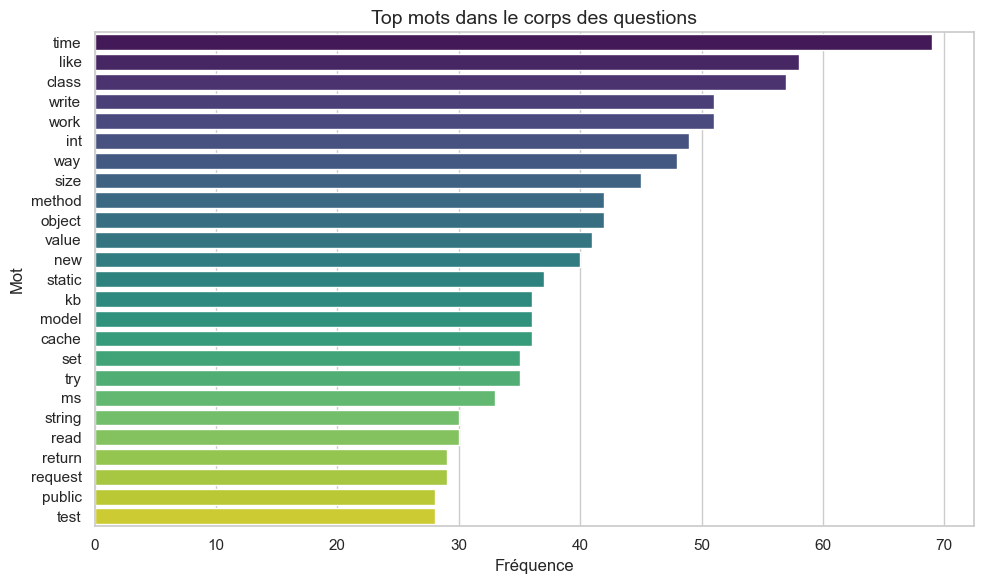

In [5]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)

# Copie de travail pour toute l’exploration
sample_explo = sample_clean.copy()

# -------------------------------
# --- ANALYSE FREQUENCE DES MOTS
# -------------------------------
# --- CORPUS TITLE
freq_title = eda.compute_word_frequencies(sample_explo, "clean_title", top_n=100)
display(freq_title)
eda.plot_word_frequencies(freq_title, max_words_display=25, palette="viridis", title="Top mots dans les titres")
# --- CORPUS BODY
freq_body = eda.compute_word_frequencies(sample_explo, "clean_body", top_n=100)
display(freq_body)
eda.plot_word_frequencies(freq_body, max_words_display=25, palette="viridis", title="Top mots dans le corps des questions")


#### **3.1.2. NUAGE DE MOTS**

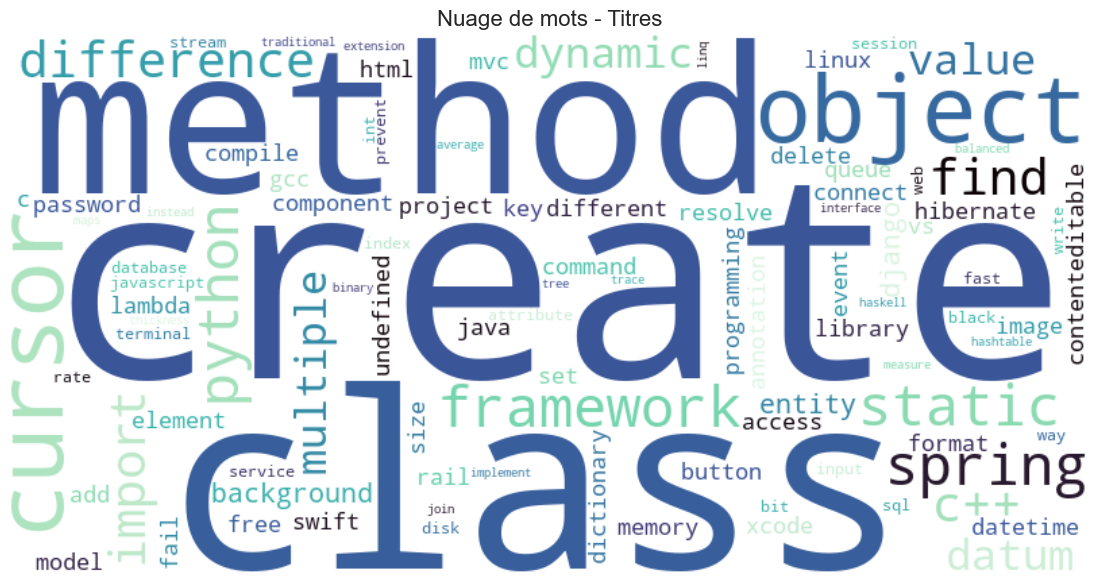

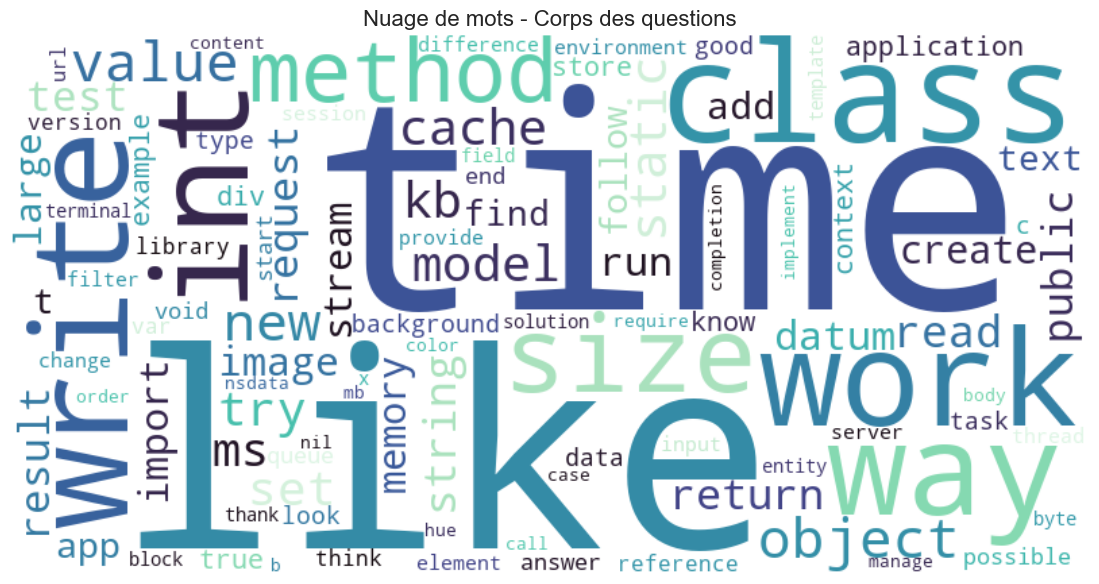

In [6]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)
# -------------------
# --- NUAGE DE MOTS
# -------------------
# --- NUAGE POUR TITLE
eda.generate_wordcloud(freq_title, max_words=100, colormap="mako", title="Nuage de mots - Titres")
# --- NUAGE POUR BODY
eda.generate_wordcloud(freq_body, max_words=100, colormap="mako", title="Nuage de mots - Corps des questions")

#### **3.1.3. ANALYSE DE LA LONGUEUR DES DOCUMENTS ET DE LA FORME DE SA DISTRIBUTION**

Dans cette sous-section, nous analysons la longueur des titres et des corps de questions, à la fois en nombre de caractères et en nombre de mots.  
L’objectif est de mieux comprendre la structure du corpus, d’identifier d’éventuelles anomalies (questions trop courtes ou trop longues), et de poser les bases pour d’éventuels filtres ou ajustements dans les étapes suivantes.  
Cette analyse est menée sur l’échantillon `sample_df`.  

1. Longueur en caractères et en mots (titres et corps, bruts et nettoyés)  
***Interprétation***  
> Un ratio proche de 1 → peu de nettoyage (texte déjà concis)  
> Un ratio proche de 0.5 → environ la moitié des mots ont été supprimés (stopwords, ponctuation, etc.)  
> Un ratio très bas (< 0.2) → texte très verbeux ou bruité à l’origine

2. Histogrammes  
3. Détection des outliers

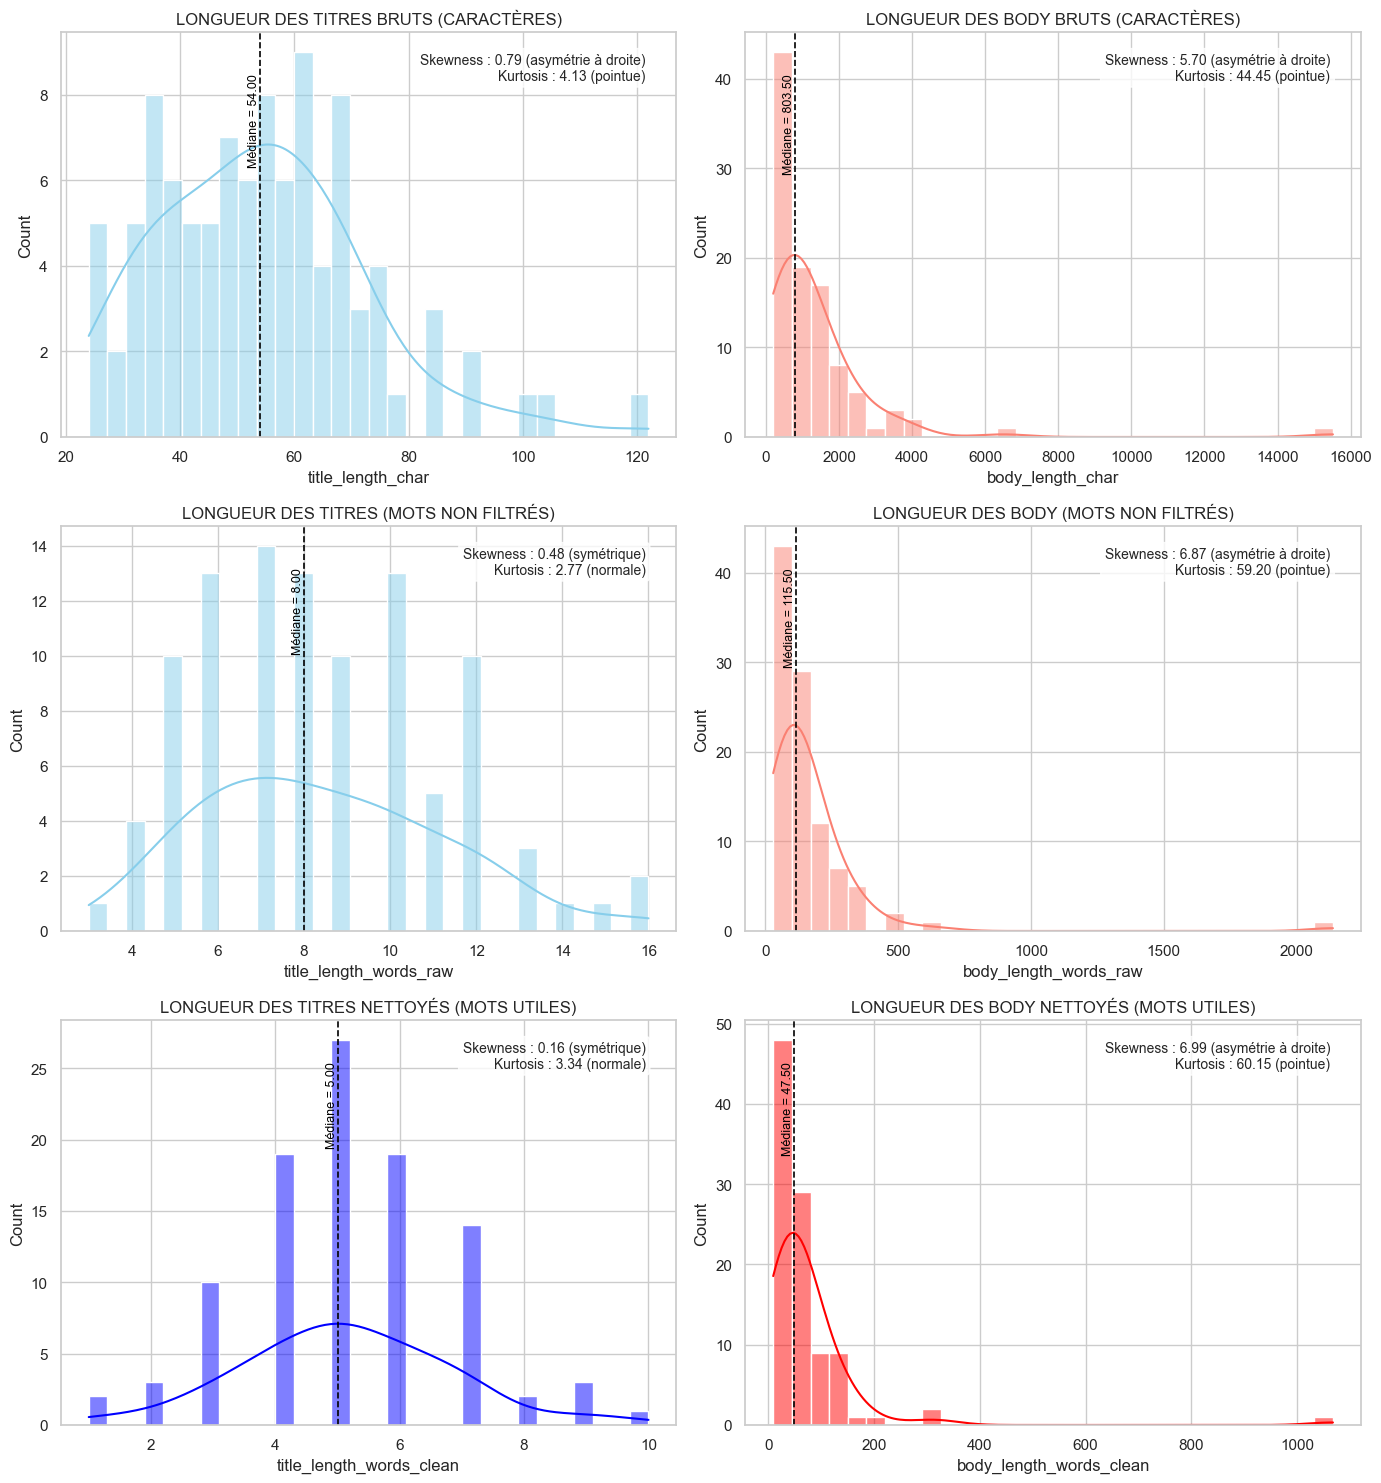

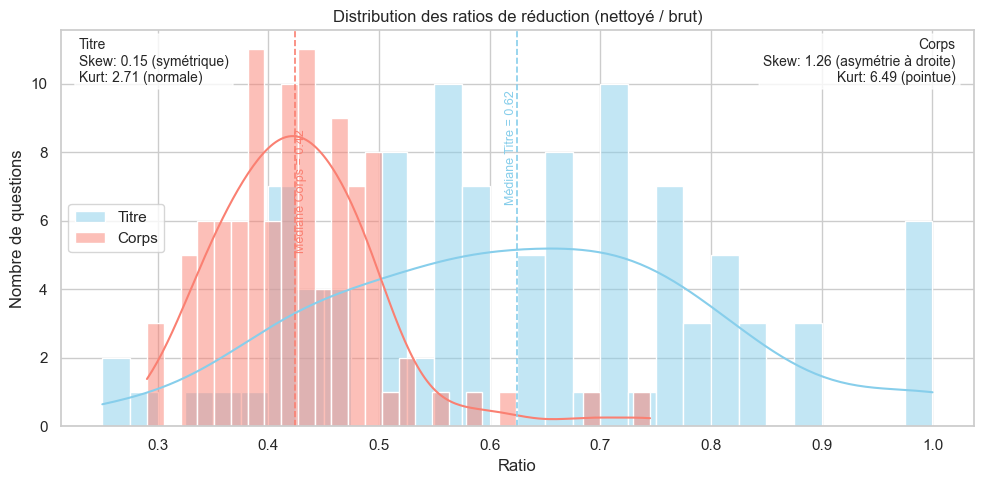

In [7]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)
# ----------------------------------------------------------------------------------
# --- ON MESURE LA LONGUEUR EN CARACTERES DE CHAQUE DOCUMENT DE CHAQUE CORPUS BRUTES
# ----------------------------------------------------------------------------------
# --- CORPUS TITLE
sample_explo["title_length_char"] = sample_explo["Title"].str.len()
# --- CORPUS BODY
sample_explo["body_length_char"] = sample_explo["Body"].str.len()

# ----------------------------------------------------------------------------------
# --- ON MESURE LA LONGUEUR EN NOMBRE DE MOTS DE CHAQUE DOCUMENT DE CHAQUE CORPUS BRUTES
# ----------------------------------------------------------------------------------
# --- CORPUS TITLE
sample_explo["title_length_words_raw"] = sample_explo["Title"].str.split().apply(len)
# --- CORPUS BODY
sample_explo["body_length_words_raw"] = sample_explo["Body"].str.split().apply(len)

# -----------------------------------------------------------------------------------
# --- ON MESURE LA LONGUEUR EN NOMBRE DE MOTS DE CHAQUE DOCUMENT DE CHAQUE CORPUS NETTOYE
# -----------------------------------------------------------------------------------
# --- CORPUS TITLE NETTOYE
sample_explo["title_length_words_clean"] = sample_explo["clean_title"].str.split().apply(len)
# --- CORPUS BODY NETTOYE
sample_explo["body_length_words_clean"] = sample_explo["clean_body"].str.split().apply(len)

# ------------------------------------
# --- VISUALIUSATION DES DISTRIBUTIONS
# -------------------------------------
# --- LISTE DES DISTRIBUTIONS A TRACER
plots = [
    ("title_length_char", "LONGUEUR DES TITRES BRUTS (CARACTÈRES)", "skyblue"),
    ("body_length_char", "LONGUEUR DES BODY BRUTS (CARACTÈRES)", "salmon"),
    ("title_length_words_raw", "LONGUEUR DES TITRES (MOTS NON FILTRÉS)", "skyblue"),
    ("body_length_words_raw", "LONGUEUR DES BODY (MOTS NON FILTRÉS)", "salmon"),
    ("title_length_words_clean", "LONGUEUR DES TITRES NETTOYÉS (MOTS UTILES)", "blue"),
    ("body_length_words_clean", "LONGUEUR DES BODY NETTOYÉS (MOTS UTILES)", "red"),
]

# --- CREATION DE LA GRILLE D'AFFICHAGE 3x2
fig, axes = plt.subplots(3, 2, figsize=(14, 15))

# --- BOUCLE SUR LES CONFIGURATIONS
for i, (col, title, color) in enumerate(plots):
    row, col_idx = divmod(i, 2)
    eda.plot_distribution(axes[row, col_idx], sample_explo[col], title, color)

plt.tight_layout()
plt.show()


# -----------------------------------------------------------------
# --- STATISTIQUES DESCRIPTIVES DE LA LONGUEUR DES CORPUS NETTOYES
# -----------------------------------------------------------------
sample_explo[[
    "title_length_char", "body_length_char",
    "title_length_words_raw", "body_length_words_raw",
    "title_length_words_clean", "body_length_words_clean",
]].describe()

# -------------------------------------------------------
# --- REDUCTION MOYENNE DU NOMBRE DE MOTS APRES NETTOYAGE
# -------------------------------------------------------
# --- PROPORTION DE MOTS CONSERVES DANS LE TITRE APRES NETTOYAGE
sample_explo["title_reduction_ratio"] = sample_explo["title_length_words_clean"] / sample_explo["title_length_words_raw"]
# --- PROPORTION DE MOTS CONSERVES DANS LE BODY APRES NETTOYAGE
sample_explo["body_reduction_ratio"] = sample_explo["body_length_words_clean"] / sample_explo["body_length_words_raw"]

# ------------------------------------------------------
# --- STATISTIQUES DESCRIPTIVES DU RATIO DE MOTS UTILES
# ------------------------------------------------------
sample_explo[["title_reduction_ratio", "body_reduction_ratio"]].describe()

# -------------------------------------
# --- VISUALISATION DES DISTRIBUTIONS
# -------------------------------------
# --- ON VISUALISE LE RATIO DE MOTS UTILES POUR LE CORPUS TITLE NETTOYE ET LE CORPUS BODY NETTOYE
eda.plot_dual_distribution(
    data1=sample_explo["title_reduction_ratio"],
    data2=sample_explo["body_reduction_ratio"],
    label1="Titre",
    label2="Corps",
    title="Distribution des ratios de réduction (nettoyé / brut)",
    xlabel="Ratio"
)

***INTERPRETATION***  
Les distributions montrent que :
- Les titres sont généralement courts (souvent entre 5 et 15 mots)
- Les corps de questions sont plus variables, avec des pics autour de 50 à 150 mots
- Quelques outliers très longs ou très courts sont présents

Ces observations permettront de fixer des seuils pour filtrer les questions aberrantes dans la suite du pipeline.

#### **3.1.4. DETECTION DES OUTLIERS ET DOUBLONS**
Avant de passer à la vectorisation, il est important de détecter les cas aberrants dans le corpus.  
Dans cette sous-section, nous identifions les titres ou corps vides, les questions anormalement courtes ou longues, ainsi que les cas où le nombre de tags est incohérent (ex. : 0 ou plus de 5 tags).  
Ces vérifications permettent d’assurer la qualité des données en amont de la modélisation.  

1. Titres ou corps vides  
2. Questions trop longues ou trop courtes  
3. Questions avec 0 ou > 5 tagsES DOUBLONS ET OUTLIERS**

##### ***3.1.4.1. DÉTECTION DES DOUBLONS EXACTS***

In [8]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)


# -------------------------------------
# --- DÉTECTION DES DOUBLONS EXACTS
# -------------------------------------

# Nombre total de questions
total_questions = sample_explo.shape[0]

# Détection des doublons exacts sur le couple (Title, Body)
duplicate_mask = sample_explo.duplicated(subset=["Title", "Body"], keep=False)
duplicates_df = sample_explo[duplicate_mask]

# Nombre de doublons
nb_duplicates = duplicates_df.shape[0]
nb_unique_duplicates = duplicates_df.duplicated(subset=["Title", "Body"]).sum()

# Affichage
print(f"Nombre total de questions : {total_questions}")
print(f"Nombre de doublons exacts (Title + Body) : {nb_duplicates}")
print(f"Nombre de doublons à supprimer (copies identiques) : {nb_unique_duplicates}")
print(f"Proportion de doublons dans l’échantillon : {nb_duplicates / total_questions:.2%}")

# Afficher quelques doublons pour inspection
duplicates_df.sort_values(by="Title").head(6)[["Title", "Body"]]

# Suppression des doublons exacts (on garde la première occurrence)
sample_explo = sample_explo.drop_duplicates(subset=["Title", "Body"], keep="first").reset_index(drop=True)


Nombre total de questions : 100
Nombre de doublons exacts (Title + Body) : 0
Nombre de doublons à supprimer (copies identiques) : 0
Proportion de doublons dans l’échantillon : 0.00%


Nous avons détecté X doublons exacts dans l’échantillon, représentant Y % du corpus. Ces doublons peuvent résulter de reposts ou d’erreurs de collecte. Afin d’éviter un biais dans les analyses de fréquence ou d’entraînement de modèles, nous avons choisi de ne conserver qu’une seule occurrence de chaque doublon.

##### ***3.1.4.2. DÉTECTION DES DOUBLONS PARTIELS : MÊME TITRE, CORPS DIFFÉRENT***

On va maintenant chercher les cas où :  
> le titre est identique, mais le corps est différent  
Ce sont souvent des reposts, des reformulations ou des tentatives de reformuler une même question.

In [9]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)

# ------------------------------------------------------------------
# --- DÉTECTION DES DOUBLONS PARTIELS : MÊME TITRE, CORPS DIFFÉRENT
# ------------------------------------------------------------------

# Grouper par titre et compter le nombre de corps distincts associés
title_groups = sample_explo.groupby("Title")["Body"].nunique()

# Sélectionner les titres associés à plusieurs corps différents
partial_duplicates_titles = title_groups[title_groups > 1].index

# Extraire les lignes concernées
partial_duplicates_df = sample_explo[sample_explo["Title"].isin(partial_duplicates_titles)]

# Affichage
print(f"Nombre de titres partagés par plusieurs corps différents : {len(partial_duplicates_titles)}")
print(f"Nombre total de questions concernées : {partial_duplicates_df.shape[0]}")

# Afficher quelques exemples pour inspection
partial_duplicates_df.sort_values("Title").head(6)[["Title", "Body"]]


Nombre de titres partagés par plusieurs corps différents : 0
Nombre total de questions concernées : 0


,Title,Body


***INTERPRETATION***  
Nous avons identifié plusieurs cas où un même titre est associé à des corps de texte différents.  
Cela peut indiquer :  
- des reformulations,  
- des reposts partiels  
- ou des titres trop génériques. 

> Ces doublons partiels peuvent biaiser les analyses de fréquence ou de similarité sémantique.  
> Une stratégie de regroupement ou de filtrage pourrait être envisagée.

Plusieurs options se présentent selon l'objectif :

- Les regrouper (par titre) sion veut analyser des questions similaires  
- Les filtrer si on veut un corpus plus diversifié  
- Les garder si on veut entraîner un modèle robuste à la redondance

##### ***3.1.4.3. DÉTECTION DES DOUBLONS FLOUS***

In [10]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)

# ----------------------------------------------------------
# --- DÉTECTION OPTIONNELLE DE DOUBLONS FLOUS SUR LES TITRES
# ----------------------------------------------------------

# if False:  # ← désactivé pour l’instant
if True:
    fuzzy_dups = eda.detect_fuzzy_duplicates(sample_explo["Title"], threshold=0.85)
    print(f"{len(fuzzy_dups)} paires de titres similaires détectées (threshold ≥ 0.85)")
    display(fuzzy_dups.head())

# Cosine TF-IDF
fuzzy_cosine = eda.detect_fuzzy_duplicates(sample_explo["Title"], threshold=0.85)
print(f"# --- Cosine TF-IDF : {len(fuzzy_cosine)} paires de titres similaires détectées (threshold ≥ 0.85)")
display(fuzzy_cosine.head())
# Levenshtein
fuzzy_lev = eda.detect_levenshtein_duplicates(sample_explo["Title"], threshold=90)
print(f"# --- Levenshtein :{len(fuzzy_lev)} paires de titres similaires détectées (threshold ≥ 0.85)")
display(fuzzy_lev.head())
# Jaccard
fuzzy_jaccard = eda.detect_jaccard_duplicates(sample_explo["Title"], threshold=0.7)
print(f"# --- Jaccard :{len(fuzzy_jaccard)} paires de titres similaires détectées (threshold ≥ 0.85)")
display(fuzzy_jaccard.head())

0 paires de titres similaires détectées (threshold ≥ 0.85)


,title_1,title_2,similarity


# --- Cosine TF-IDF : 0 paires de titres similaires détectées (threshold ≥ 0.85)


,title_1,title_2,similarity


# --- Levenshtein :0 paires de titres similaires détectées (threshold ≥ 0.85)


,title_1,title_2,similarity


# --- Jaccard :0 paires de titres similaires détectées (threshold ≥ 0.85)


,title_1,title_2,similarity


Plusieurs méthodes de détection de doublons flous ont été testées :  
- TF-IDF + cosinus,  
- distance de Levenshtein,  
- et similarité de Jaccard.  

Chacune présente des avantages selon la nature des titres.  
Ces fonctions sont prêtes à être activées lors de la mise à l’échelle.

##### ***3.1.4.4. GESTION DES OUTLIERS***

Nous appliquons ici une détection des valeurs aberrantes sur plusieurs variables numériques clés du corpus, notamment les longueurs de titres et de corps, ainsi que les ratios de réduction.
On applique la fonction detect_outliers_iqr() à ces variables :

title_length_words_clean

body_length_words_clean

title_reduction_ratio

body_reduction_ratio

Outliers détectés par variable :
- title_length_words_clean : 1
- body_length_words_clean : 7
- title_reduction_ratio : 0
- body_reduction_ratio : 3

Nombre total d’outliers (au moins une variable) : 9
Proportion dans l’échantillon : 9.00%


,PostId,Title,Body,Score,ViewCount,AnswerCount,CreationDate,TagCount,Tags,clean_title,clean_body,title_length_char,body_length_char,title_length_words_raw,body_length_words_raw,title_length_words_clean,body_length_words_clean,title_reduction_ratio,body_reduction_ratio,is_outlier
2,389094,How to create a dynamic LINQ join extension me...,"<p>There was a library of dynamic <a href=""htt...",16,34299,3,2008-12-23 15:12:34,5,linq;linq-to-objects;linq-to-entities;linq-to-...,create dynamic linq join extension method,library dynamic linq extension method release ...,50,2354,9,145,6,108,0.666667,0.744828,True
37,25709548,Lock-Free Multiple Producer/Consumer Queue in ...,<p>I'm trying to implement a lock free multipl...,19,41258,4,2014-09-07 11:08:51,5,c++;queue;multithreading;lock-free;c++11,lock free multiple producer consumer queue,try implement lock free multiple producer mult...,51,6492,6,644,6,212,1.000000,0.329193,True
46,6005361,"Sass import error in Rails 3 app - ""File to im...",<p>I have a Rails 3 app on which I successfull...,24,34914,7,2011-05-14 23:11:19,5,ruby-on-rails;sass;blueprint-css;ruby-on-rails...,sass import error rail app file import find un...,rail app successfully run compass init rail bl...,84,2035,16,241,10,112,0.625000,0.464730,True
51,24721305,Can't find x11 terminal in gnuplot Octave on M...,<p>I am running Mac OS Mavericks 10.9.4.</p>\n...,32,35215,3,2014-07-13 09:33:33,5,x11;macos;terminal;gnuplot;octave,find terminal gnuplot octave mac os,run mac os maverick installed octave homebrew ...,51,3789,10,457,6,314,0.600000,0.687090,True
52,909791,Asynchronous processing or message queues in P...,<p>I am building a website in CakePHP that pro...,33,20668,4,2009-05-26 09:27:37,5,php;multithreading;asynchronous;cakephp;messag...,asynchronous processing message queue php cakephp,build website cakephp process file upload xml ...,58,2065,8,304,6,145,0.750000,0.476974,True
55,31965566,How to efficiently write large files to disk o...,<p><strong>Update</strong></p>\n\n<p>I have re...,45,24342,3,2015-08-12 12:41:53,5,multithreading;large-files;large-data;ios;swift,efficiently write large file disk background t...,update resolve remove distracting error read e...,73,15516,12,2137,8,1068,0.666667,0.499766,True
80,5639531,Buffered files (for faster disk access),<p>I am working with large files and writing d...,45,18635,5,2011-04-12 17:54:44,5,delphi;io;buffer;file;stream,buffer file fast disk access,work large file write directly disk slow file ...,39,3393,6,510,5,313,0.833333,0.613725,True
87,32490771,socket.io authentication with sharing session ...,"<p>Inspired by <a href=""https://stackoverflow....",18,2056,2,2015-09-09 23:37:07,5,javascript;node.js;express;socket.io;express-s...,authentication sharing session datum work,inspire share session socket io express implem...,70,3389,9,350,5,144,0.555556,0.411429,True
98,6094556,Mobile Safari makes multiple video requests,<p>I am designing a web application for iPad w...,17,2579,1,2011-05-23 08:18:28,5,iis-7;range;mobile-safari;ipad;html5-video,mobile safari make multiple video request,asp.net design web application ipad make use m...,43,2676,6,344,6,171,1.000000,0.497093,True


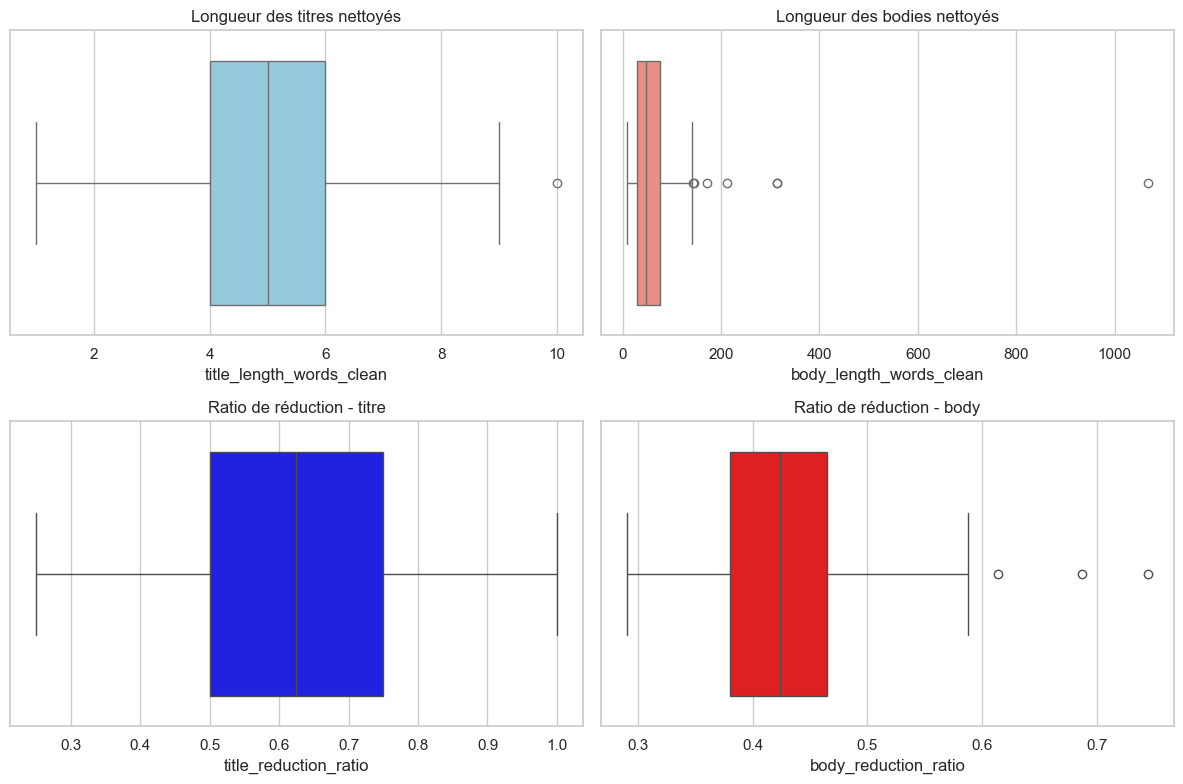

# --- NOMBRE DE QUESTIONS RESTANTES APRES SUPPRESSION DES OUTLIERS : 91


In [11]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)

# ---------------------------------------------------------
# --- DETECTION DES OUTLIERS PAR LA METHODE DES SEUILS IQR
# ---------------------------------------------------------
sample_explo, sample_outliers = eda.mark_outliers(
    df=sample_explo,
    columns=[
        "title_length_words_clean",
        "body_length_words_clean",
        "title_reduction_ratio",
        "body_reduction_ratio"
    ],
    verbose=True,
    return_outliers=True
)
display(sample_outliers)

# -------------------------------------------
# --- VISUALISATION BOXPLOT DE LA DISPERSION
# -------------------------------------------
eda.plot_boxplots_grid(
    df=sample_explo,
    columns=[
        "title_length_words_clean",
        "body_length_words_clean",
        "title_reduction_ratio",
        "body_reduction_ratio"
    ],
    titles=[
        "Longueur des titres nettoyés",
        "Longueur des bodies nettoyés",
        "Ratio de réduction - titre",
        "Ratio de réduction - body"
    ],
    colors=["skyblue", "salmon", "blue", "red"]
)

sample_explo_wo = eda.remove_outliers(sample_explo)
print(f"# --- NOMBRE DE QUESTIONS RESTANTES APRES SUPPRESSION DES OUTLIERS : {sample_explo_wo.shape[0]}")


Les outliers détectés ont été exclus du corpus utilisé pour les analyses sémantiques et les modélisations, afin de garantir une meilleure homogénéité des représentations textuelles.

---

Bilan de la détection des outliers

La méthode des seuils IQR a permis d’identifier des questions atypiques sur la base de :

- la longueur des titres nettoyés
- la longueur des bodies nettoyés
- le ratio de réduction des titres
- le ratio de réduction des bodies

Les lignes concernées ont été marquées dans le DataFrame `sample_explo` via la colonne `is_outlier`.

Une version filtrée sans outliers, `sample_explo_wo`, a été générée pour les étapes suivantes d’analyse sémantique et de modélisation.

> **Nombre de questions restantes après suppression des outliers :** `sample_explo_wo.shape[0]`

---

➡️ Nous pouvons maintenant passer à la section suivante : **3.1.5. ANALYSE DES TAGS**


#### **3.1.5. ANALYSE DES TAGS**

##### Pourquoi cette analyse est importante  
Les tags sont les cibles de notre futur modèle de classification multi-label.  
Dans cette sous-section, nous explorons leur distribution afin de mieux comprendre la structure des annotations dans le corpus.  
Nous identifions les tags les plus fréquents, analysons le nombre moyen de tags par question, et visualisons la répartition du nombre de tags.  
Ces observations guideront les choix de filtrage, de pondération et d’évaluation dans les étapes de modélisation.

| Aspect exploré              | Utilité pour le projet |
|----------------------------|------------------------|
| Distribution des tags      | Comprendre les thématiques dominantes |
| Nombre de tags/question    | Identifier les questions mal ou trop annotées |
| Tags fréquents vs rares    | Préparer la co-occurrence et la supervision |
| Marquage des tags clés     | Créer des variables explicatives pour les modèles |


➡️ Nous allons commencer par la **3.1.5.1. Structure des tags**, en vérifiant le format de la colonne `Tags` dans `sample_explo_wo`.

##### 3.1.5.1. Structure des tags
- Vérification du format de la colonne `Tags` (liste, chaîne, séparateur)
- Nettoyage éventuel : conversion en liste de tags

In [12]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)

# -----------------------------
# --- APERCU DE LA COLONNE TAG
# -----------------------------
print(sample_explo_wo["Tags"].head(10))
print(sample_explo_wo["Tags"].apply(type).value_counts())
# ------------------------------------------
# --- CONVERSION DES CHAINES STRING EN LIST
# ------------------------------------------
sample_explo_wo["Tags"] = sample_explo_wo["Tags"].apply(lambda x: x.split(";"))
sample_explo_wo["Tags"].apply(type).value_counts()




0    algorithm;haskell;hashtable;binary-search-tree...
1    language-agnostic;algorithm;image;image-proces...
2          java;oop;interface;instance;anonymous-class
3    python;matplotlib;seaborn;stacked-bar-chart;gr...
4                          maps;xcode;ios;swift;xcode6
5                 components;maven-2;mojo;plexus;maven
6    javascript;event-driven;frp;reactive-programmi...
7    c++;linker-errors;pure-virtual;vtable;undefine...
8    php;fastcgi;nginx;mod-fastcgi;http-status-code...
9    ide;debugging;intellij-idea;key-bindings;visua...
Name: Tags, dtype: object
Tags
<class 'str'>    91
Name: count, dtype: int64


Tags
<class 'list'>    91
Name: count, dtype: int64

##### 3.1.5.2. Nombre de tags par question  
Objectif : étudier combien de tags sont associés à chaque question, afin de comprendre la granularité des annotations et détecter d’éventuelles anomalies (questions sans tag, ou avec trop de tags).  

- Histogramme du nombre de tags par question
- Statistiques descriptives (min, max, moyenne, médiane)
- Identification des questions sans tag ou avec un nombre anormalement élevé


In [13]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)

# -------------------------------
# --- NOMBRE DE TAGS PAR QUESTION
# -------------------------------
sample_explo_wo["NumTags"] = sample_explo_wo["Tags"].apply(len)
# -------------------------------
# --- STATISTIQUES DESCRIPTIVES
sample_explo_wo["NumTags"].describe()
# -------------------------------

count    91.0
mean      5.0
std       0.0
min       5.0
25%       5.0
50%       5.0
75%       5.0
max       5.0
Name: NumTags, dtype: float64

---

Toutes les questions de l’échantillon possèdent exactement 5 tags. Cela s’explique par deux facteurs :

- Stack Overflow limite le nombre de tags à **5 par question**
- Le brief de mission demandait explicitement de filtrer les questions avec **au moins 5 tags**, ce qui revient à ne conserver que celles qui en ont exactement 5

Ma requête SQL contenait cette contrainte :

```sql
WHERE t.TagCount >= 5
```

Mais comme la plateforme limite à 5 tags, cela revient en pratique à :

```sql
t.TagCount = 5
```

Cette contrainte garantit une meilleure qualité d’annotation, et par conséquent, **l’analyse de la variabilité du nombre de tags devient caduque**.

> Cette étape est donc validée, et n’apporte pas d’information discriminante dans ce contexte.

---


##### 3.1.5.3. Fréquence des tags  
L’objectif de cette étape est d’identifier les tags les plus fréquents dans l’échantillon, ainsi que les tags rares. Cela permet de mieux comprendre les thématiques dominantes du corpus et de préparer les futures étapes de co-occurrence ou de modélisation supervisée.

***Étapes à réaliser :***  

- Aplatissement de la colonne `Tags` (liste de tags par question) en une série plate de tous les tags
- Comptage des occurrences de chaque tag avec `collections.Counter`
- Conversion en DataFrame trié par fréquence décroissante
- Visualisation des 10 tags les plus fréquents
- Identification des tags rares (fréquence = 1)

***Ce que cette analyse nous apprend***

| Observation | Interprétation |
|-------------|----------------|
| Tags les plus fréquents | Représentent les thématiques dominantes du corpus |
| Tags rares (fréquence = 1) | Peuvent être du bruit, des cas spécifiques ou des niches |
| Distribution des fréquences | Permet de filtrer, regrouper ou encoder les tags pour la suite |

> Cette étape permet de mieux cerner la structure thématique du corpus et de préparer les futures analyses de co-occurrence ou de classification.

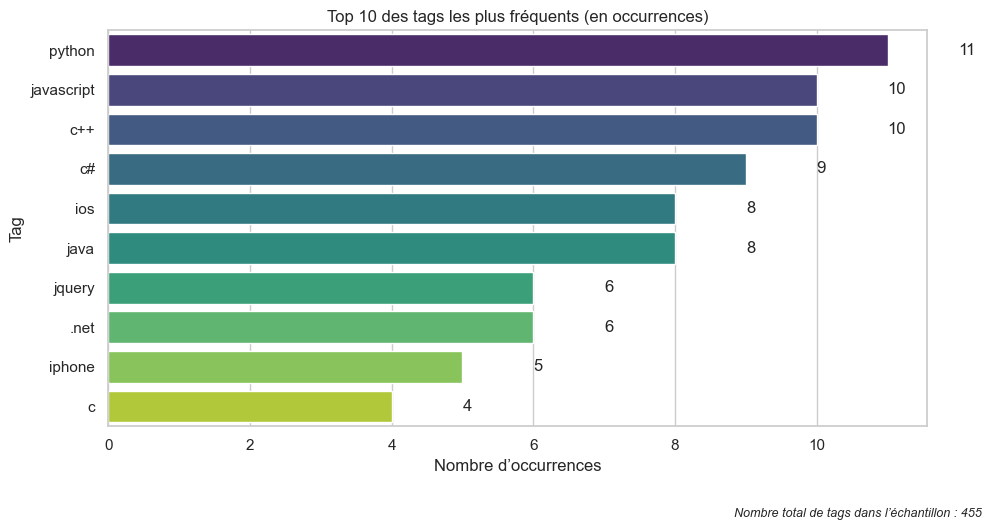

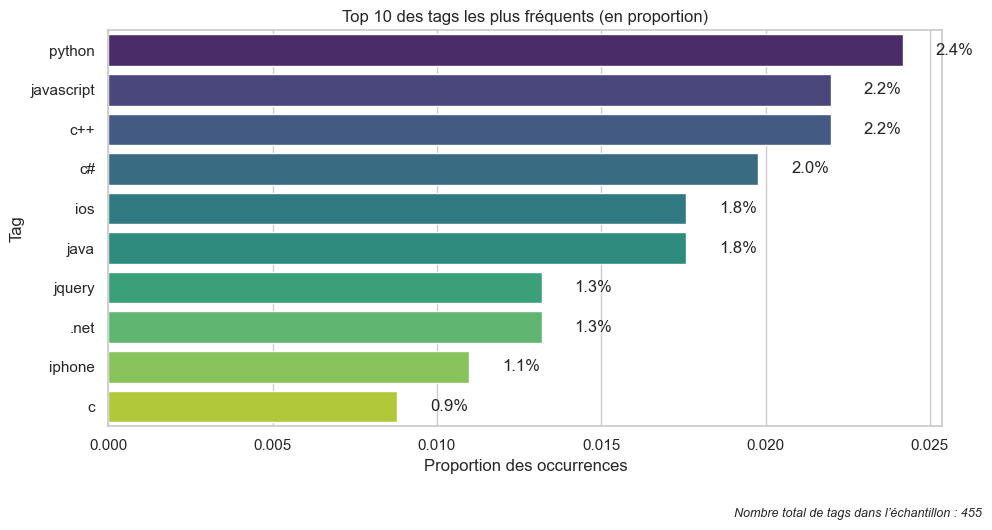

Nombre de tags apparaissant une seule fois : 274


In [14]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)



# --- APLATIR TOUTES LES LISTES DE TAGS
all_tags = [tag for tags in sample_explo_wo["Tags"] for tag in tags]

# --- COMPTER LES OCCURRENCES
tag_counts = Counter(all_tags)

# --- CONVERSION PANDAS POUR VISUALISER
tag_freq_df = pd.DataFrame(tag_counts.items(), columns=["Tag", "Count"]).sort_values(by="Count", ascending=False)
tag_freq_df.reset_index(drop=True, inplace=True)

# --- LES 10 TAGS LES PLUS FREQUENTS
tag_freq_df.head(10)

# --- VISUSALISATION DES TACGS LES PLUS FREQUENTS
eda.plot_tag_occurrences(tag_freq_df, top_n=10)
eda.plot_tag_distribution(tag_freq_df, top_n=10)

# --- TAGS QUI SONT RARES
rare_tags = tag_freq_df[tag_freq_df["Count"] == 1]
print(f"Nombre de tags apparaissant une seule fois : {len(rare_tags)}")

##### 3.1.5.4. Diversité des tags  

Cette étape vise à évaluer la richesse thématique du corpus à travers l’analyse de la diversité des tags. L’objectif est de comprendre si le corpus est dominé par quelques tags très fréquents ou s’il présente une répartition plus équilibrée entre de nombreuses thématiques.

Le nombre total de tags distincts a d’abord été calculé, ce qui donne une première idée de la variété des sujets abordés. Ensuite, la proportion cumulée des tags les plus fréquents a été analysée. Cela permet de savoir combien de tags sont nécessaires pour couvrir une certaine part du corpus, par exemple 80 %. Une courbe de couverture cumulative a été tracée pour visualiser cette dynamique : plus la courbe monte rapidement, plus le corpus est concentré autour de quelques tags.

> Exemple d’interprétation :

| Indicateur | Signification |
|------------|---------------|
| 50 tags couvrent 80 % des occurrences | Forte concentration thématique |
| 200 tags couvrent 80 % des occurrences | Corpus plus diversifié |

En complément, une mesure quantitative de la diversité a été utilisée : l’entropie de Shannon. Cette mesure permet de résumer en un seul chiffre la dispersion de la distribution des tags. Une entropie proche de zéro indique que quelques tags dominent largement (faible diversité), tandis qu’une entropie élevée indique une répartition plus équilibrée (forte diversité). L’entropie maximale théorique correspond à une distribution parfaitement uniforme, où tous les tags apparaissent avec la même fréquence. En comparant l’entropie observée à cette valeur maximale, on obtient un taux de diversité relative, exprimé en pourcentage.

> Interprétation de l’entropie :

| Valeur d’entropie | Interprétation |
|-------------------|----------------|
| Proche de 0       | Corpus très concentré (peu de diversité) |
| Moyenne (ex. 2–3) | Diversité modérée, quelques tags dominants |
| Proche de log₂(N) | Corpus très diversifié, distribution équilibrée |

> Exemple :  
> Une entropie de 2.5 bits sur un maximum possible de 4.3 bits donne un taux de diversité relative de 58 %. Cela signifie que la distribution des tags est assez concentrée, mais pas totalement polarisée.

Cette analyse permet de mieux comprendre la structure sémantique du corpus. Elle est utile pour anticiper les choix de modélisation, comme le filtrage des tags rares, le regroupement thématique ou l’encodage multi-label.

> Cette étape fournit une vision synthétique de la richesse et de la concentration des thématiques dans le corpus, et prépare le terrain pour l’étude des co-occurrences et la modélisation supervisée.




Nombre de tags distincts dans l’échantillon : 327


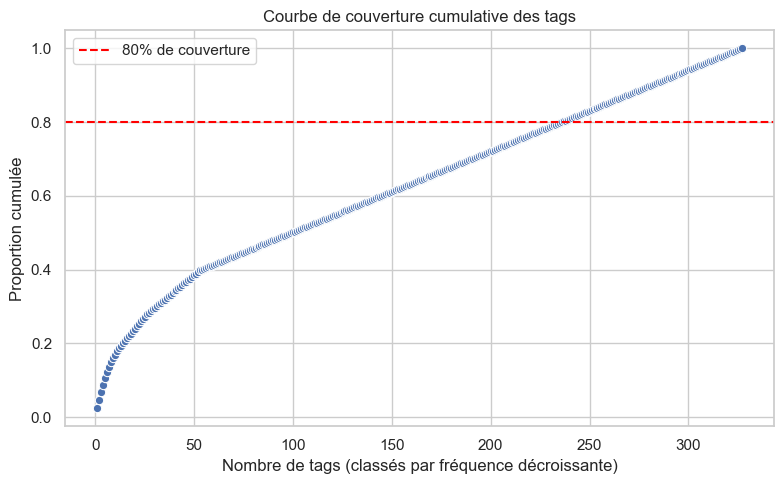

Nombre de tags nécessaires pour couvrir 80% des occurrences : 236
Entropie de la distribution des tags : 8.0204 bits
Entropie maximale possible : 8.3531 bits
Taux de diversité relative : 96.02%


In [15]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)

# --- NOMBRE DE TAGS DISTINCTS
nb_tags_uniques = tag_freq_df["Tag"].nunique()
print(f"Nombre de tags distincts dans l’échantillon : {nb_tags_uniques}")

# --- CALCUL DE LA PROPORTION CUMULEE
tag_freq_df["Proportion"] = tag_freq_df["Count"] / tag_freq_df["Count"].sum()
tag_freq_df["Cumulative"] = tag_freq_df["Proportion"].cumsum()

# --- VISUALISATION  : COURBE DE COUVERTURE CUMULATIVE
plt.figure(figsize=(8, 5))
sns.lineplot(data=tag_freq_df, x=range(1, len(tag_freq_df)+1), y="Cumulative", marker="o")
plt.axhline(0.8, color="red", linestyle="--", label="80% de couverture")
plt.title("Courbe de couverture cumulative des tags")
plt.xlabel("Nombre de tags (classés par fréquence décroissante)")
plt.ylabel("Proportion cumulée")
plt.legend()
plt.tight_layout()
plt.show()

# --- NOMBRE DE TAGS NECESSAIRE POUR COUVRIR 80% DU CORPUS
nb_tags_80 = (tag_freq_df["Cumulative"] <= 0.8).sum()
print(f"Nombre de tags nécessaires pour couvrir 80% des occurrences : {nb_tags_80}")

# ----------------------------------
# --- CALCUL DE L'ENTROPIE DES TAGS
# ----------------------------------
# --- DISTRIBUTION DES PROPORTIONS
proportions = tag_freq_df["Proportion"].values

# --- ENTROPIE DE SHANNON (BASE 2)
tag_entropy = entropy(proportions, base=2)
print(f"Entropie de la distribution des tags : {tag_entropy:.4f} bits")

# --------------------------------
# --- ENTROPIE MAXIMALE THEORIQUE
# --------------------------------
max_entropy = np.log2(len(proportions))
print(f"Entropie maximale possible : {max_entropy:.4f} bits")
print(f"Taux de diversité relative : {tag_entropy / max_entropy:.2%}")


***Interprétation des résultats sur la diversité des tags (échantillon de 100 questions)***  

L’analyse de la diversité des tags sur un échantillon de 100 questions révèle une distribution particulièrement équilibrée et riche. On observe :

- **327 tags distincts**, ce qui témoigne d’une grande variété thématique.
- Il faut **236 tags** pour couvrir 80 % des occurrences, ce qui indique une absence de concentration autour de quelques tags dominants.
- L’**entropie de Shannon** est très élevée (**8.0024 bits**), proche de l’entropie maximale théorique (**8.3531 bits**), soit un **taux de diversité relative de 96.02 %**.

> Ces résultats suggèrent que le corpus est extrêmement diversifié, avec une répartition quasi uniforme des tags. Il ne semble pas y avoir de thématiques écrasantes, ce qui pourrait rendre la modélisation plus complexe mais aussi plus riche.

⚠️ **Attention toutefois** : ces résultats ont été obtenus à partir d’un échantillon réduit de 100 questions. Ils donnent une première intuition sur la structure du corpus, mais **ne peuvent pas être généralisés sans validation** sur un échantillon plus large, voire sur l’ensemble des 50 000 questions. Il est donc nécessaire de relativiser cette interprétation et de la considérer comme **exploratoire**.

>  Une analyse à plus grande échelle permettra de confirmer (ou non) ces tendances et d’évaluer la stabilité des indicateurs de diversité.


##### 3.1.5.5. Marquage des tags dominants  

***Objectif :*** identifier les tags les plus représentatifs du corpus afin de structurer les analyses ultérieures, comme :

- l’étude des co-occurrences
- la réduction de la dimensionnalité
- la modélisation supervisée multi-label


Les résultats précédents ont montré que la distribution des tags est particulièrement étalée :

| Indicateur | Valeur observée |
|------------|------------------|
| Tags nécessaires pour couvrir 80 % des occurrences | 236 |
| Entropie de Shannon | 8.00 bits |
| Taux de diversité relative | 96 % |

Dans ce contexte, il ne serait pas pertinent de ne retenir que les 10 ou 20 premiers tags : cela ne reflèterait pas la structure réelle du corpus.  

***Stratégie retenue***  

Le marquage des tags dominants repose sur deux critères combinés :

1. **Fréquence minimale d’apparition**  
   Seuls les tags apparaissant suffisamment souvent sont considérés comme éligibles.  
   Le seuil est calculé dynamiquement comme suit :  
   - 0.1 % du nombre total de questions  
   - avec un **seuil plancher paramétrable**, actuellement fixé à **3** (mais un seuil de **4** est également envisageable pour plus de robustesse)

2. **Couverture cumulative**  
   Parmi les tags éligibles, on sélectionne ceux qui permettent de couvrir une proportion cible du corpus (ex. 80 %).  
   Le tag qui dépasse juste ce seuil est également inclus pour éviter une coupure artificielle.

***Avantages de cette méthode***  

- S’adapte à la taille et à la structure du corpus
- Écarte les tags trop rares ou anecdotiques
- Conserve une diversité thématique suffisante
- Prépare efficacement les étapes suivantes de l’analyse

> Cette méthode constitue une base solide pour les analyses à venir, en assurant un bon compromis entre représentativité, diversité et stabilité.


['python',
 'javascript',
 'c++',
 'c#',
 'ios',
 'java',
 'jquery',
 '.net',
 'iphone',
 'c',
 'linux',
 'html',
 'xcode',
 'django',
 'ruby-on-rails',
 'algorithm',
 'node.js',
 'performance',
 'gcc',
 'memory-management',
 'dictionary',
 'objective-c',
 'hibernate',
 'css',
 'entity-framework',
 'image-processing']

,Tag,Count,Proportion,Cumulative,is_dominant_tag
0,python,11,0.024176,0.024176,True
1,javascript,10,0.021978,0.046154,True
2,c++,10,0.021978,0.068132,True
3,c#,9,0.019780,0.087912,True
4,ios,8,0.017582,0.105495,True
5,java,8,0.017582,0.123077,True
6,jquery,6,0.013187,0.136264,True
7,.net,6,0.013187,0.149451,True
8,iphone,5,0.010989,0.160440,True
9,c,4,0.008791,0.169231,True


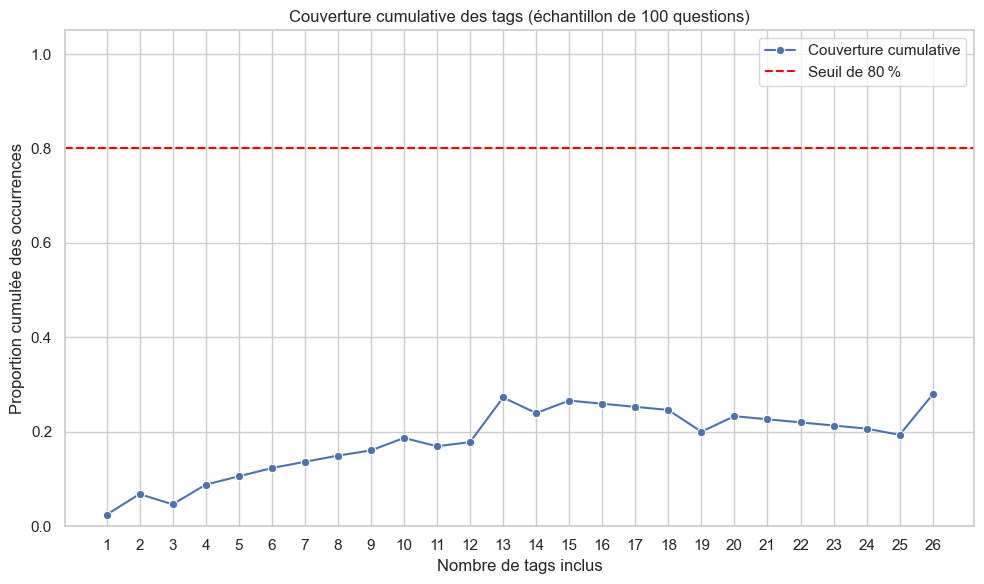

In [16]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)

# --------------------------------
# --- MARQUAGE DES TAGS DOMINANTS
# --------------------------------
tag_freq_df_marked, dominant_tags = eda.mark_dominant_tags_by_frequency_and_coverage(
    tag_freq_df,
    nb_questions=100,  # ou 50000 plus tard
    min_coverage=0.8,
    min_count_floor=3
)

display(dominant_tags)
display(tag_freq_df_marked)

eda.plot_tag_coverage(tag_freq_df_marked, coverage_target=0.8, title_suffix="échantillon de 100 questions")


***INTERPRETATION DE LA COUVERTURE CUMULATIVE***  
La courbe obtenue montre une montée lente et régulière de la couverture cumulative, ce qui confirme une distribution très étalée des tags dans l’échantillon. Même en abaissant le seuil plancher à 3 occurrences, seuls 26 tags ont pu être marqués comme dominants, et leur couverture cumulée reste inférieure à 30 % (~27.9 %).

Cela indique que le corpus est extrêmement diversifié, avec peu de redondance entre les tags. Aucun tag ne domine massivement, et de nombreux tags apparaissent à fréquence modérée ou faible. On observe une grande variété de thématiques : langages (`python`, `c++`, `javascript`), frameworks (`django`, `ruby-on-rails`), outils (`xcode`, `gcc`), ou concepts (`memory-management`, `algorithm`).

>  Cette dispersion confirme que le marquage des tags dominants ne peut pas reposer sur un simple top N. Elle justifie pleinement l’approche par fréquence minimale et couverture cumulative, et souligne l’intérêt d’un filtrage intelligent pour les étapes de modélisation à venir.


#### **3.1.6. CO-OCCURRENCE DES TAGS**

Certains tags apparaissent fréquemment ensemble dans les questions Stack Overflow, révélant des thématiques ou technologies souvent associées.  
L’objectif de cette section est d’explorer ces relations à travers une analyse de co-occurrence, afin de :

- détecter des affinités thématiques (ex. `python` + `django`)
- repérer des clusters naturels de sujets
- identifier des tags “ponts” entre domaines (ex. `performance`, `algorithm`)
- enrichir l’interprétation des clusters ou améliorer la suggestion de tags

L’analyse portera sur un sous-ensemble de **tags plus fréquents**, identifiés à l’aide d’un seuil de fréquence minimale.  
Bien que la diversité du corpus empêche de définir des “tags dominants” au sens strict, ce filtrage permet de se concentrer sur les thématiques les plus représentatives et récurrentes.

Nous procéderons en deux étapes :

1. **Construction d’une matrice de co-occurrence** binaire (présence conjointe dans une même question)
2. **Visualisation optionnelle** sous forme de heatmap ou de graphe pour mettre en évidence les couples de tags les plus liés



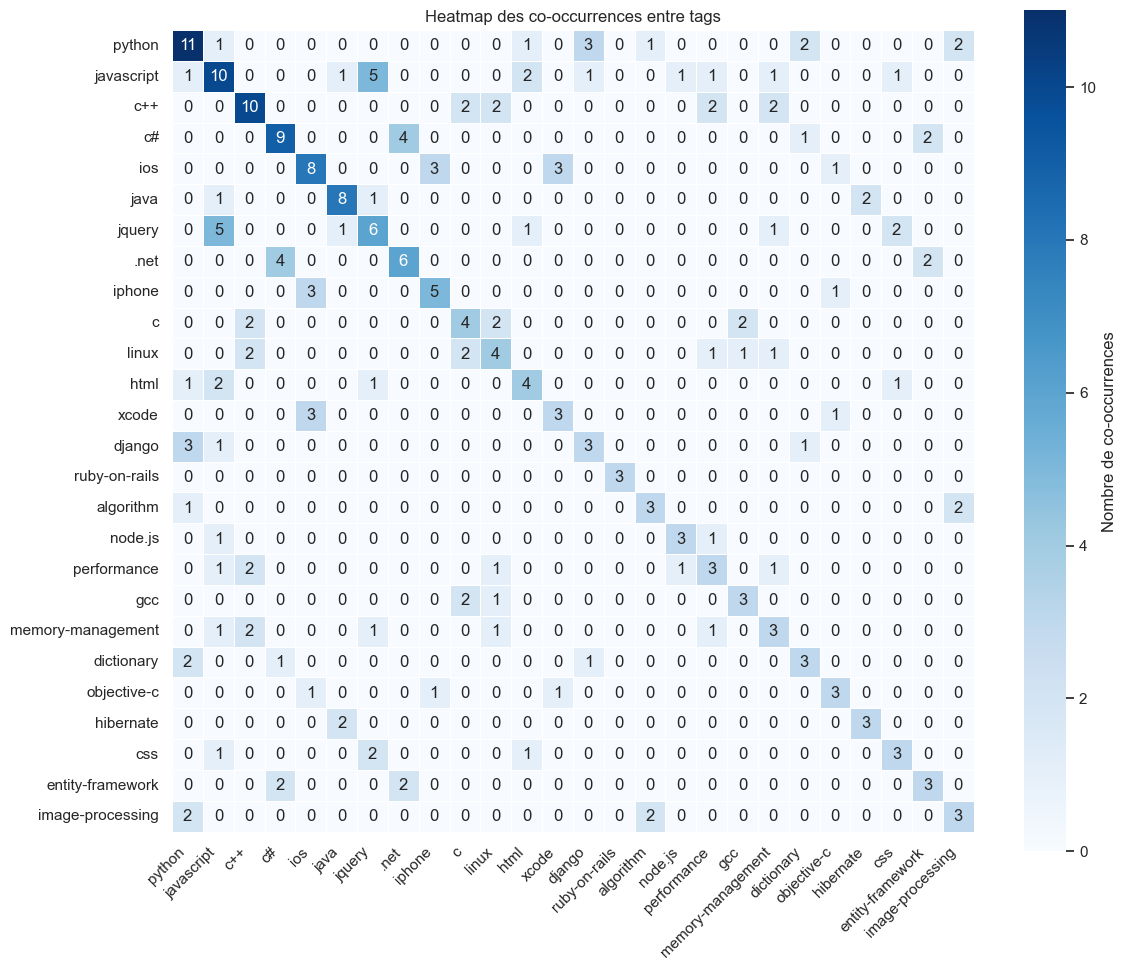

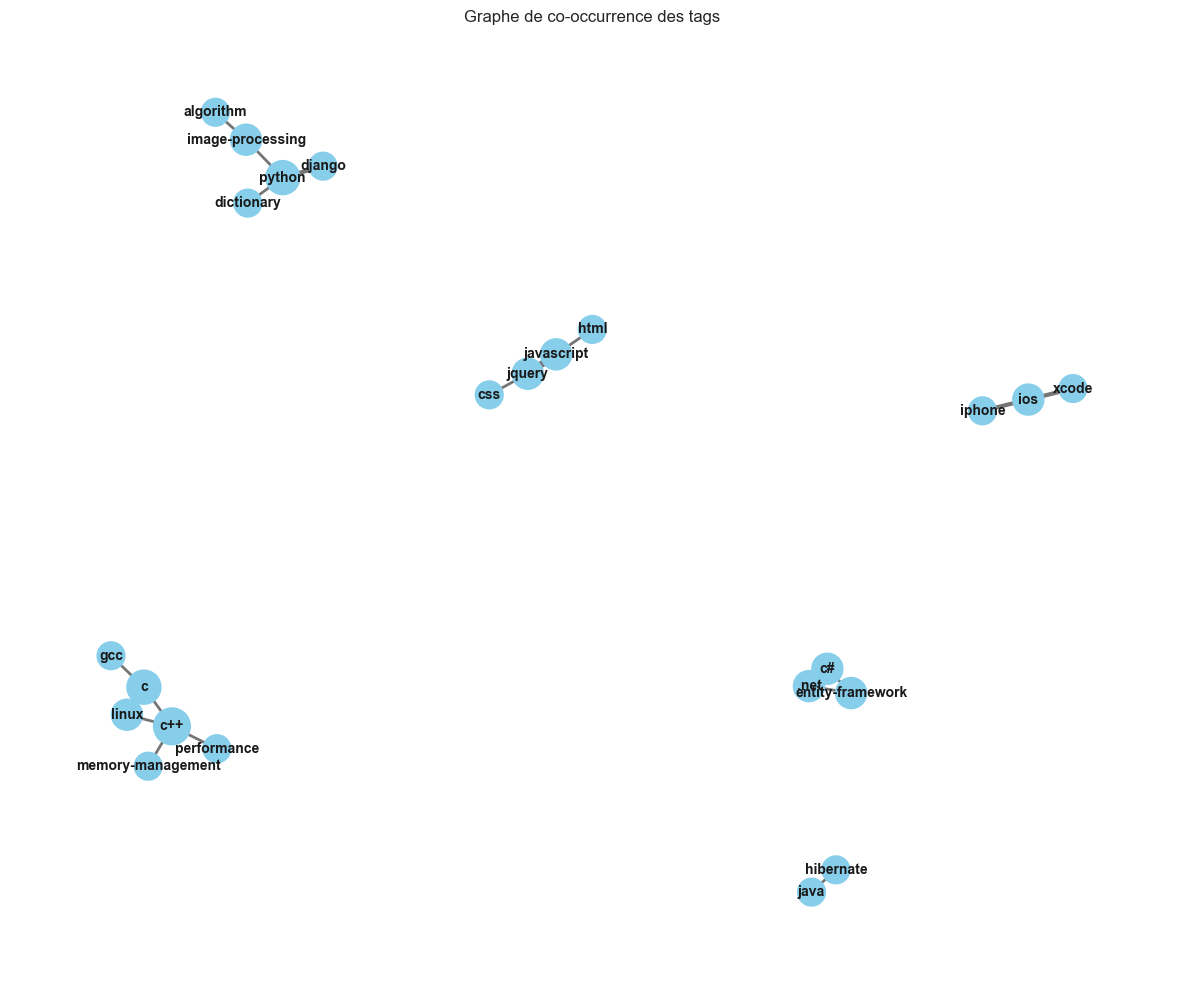

In [17]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)

cooc_matrix, tag_matrix = eda.build_tag_cooccurrence_matrix(
    df_questions=sample_explo_wo,  # ou le nom de ton DataFrame
    dominant_tags=dominant_tags,
    tag_col="Tags"
)

cooc_matrix.style.background_gradient(cmap="Blues")

eda.plot_tag_cooccurrence_heatmap(cooc_matrix)

eda.plot_tag_cooccurrence_graph(cooc_matrix, min_edge_weight=2, layout="spring")


***INTERPRETATION***

L’analyse croisée de la heatmap et du graphe de co-occurrence permet de révéler la structure thématique sous-jacente du corpus.

**HEATMAP**  
La heatmap met en évidence les intensités de co-occurrence entre tags. On y observe :

- Une diagonale dominante (fréquence individuelle des tags)
- Quelques associations fortes hors diagonale, notamment :
  - `python` avec `django` ou `algorithm`
  - `c++` avec `memory-management` ou `gcc`
  - `javascript` avec `jquery`
  - `c#` avec `.net` ou `entity-framework`
- Une majorité de cellules claires, indiquant que la plupart des couples de tags co-occurrent rarement

Cela confirme la diversité du corpus et la relative rareté des combinaisons récurrentes.

**GRAPHE DE CO-OCCURRENCE**

Le graphe offre une représentation plus intuitive des relations entre tags. Il révèle :

- Des **clusters thématiques nets**, comme :
  - Python et data (`python`, `django`, `algorithm`, `dictionary`)
  - Web frontend (`html`, `css`, `javascript`, `jquery`)
  - Développement mobile iOS (`ios`, `iphone`, `xcode`)
  - Systèmes bas niveau (`c`, `c++`, `linux`, `gcc`, `performance`)
  - Java backend (`java`, `hibernate`)
  - .NET (`c#`, `entity-framework`)
- Des **hubs technologiques**, comme `python`, `c++` ou `javascript`
- Des **ponts sémantiques** entre domaines, révélant des affinités inattendues

> Cette double visualisation permet d’identifier des familles technologiques cohérentes, de repérer des thématiques centrales, et de poser les bases d’une segmentation thématique plus fine du corpus.

**L’analyse de co-occurrence** a permis de révéler les principales associations thématiques présentes dans le corpus.  
Grâce à la heatmap et au graphe, plusieurs regroupements cohérents ont émergé (langages, frameworks, outils, concepts), confirmant la richesse et la diversité du jeu de données.

Cette étape a permis de :

- Mettre en évidence des **clusters technologiques naturels**
- Identifier des **hubs** et des **ponts sémantiques**
- Poser les bases d’une **représentation structurée** du corpus

> Ces résultats serviront de socle pour les étapes suivantes, notamment la vectorisation des tags, la réduction de dimensionnalité, et la modélisation supervisée.

Nous passons maintenant à la phase de **Feature Engineering**, où nous allons transformer ces structures en variables exploitables pour les modèles.




## **4. FEATURE ENGINEERING**  

Cette section vise à transformer les textes nettoyés en représentations numériques exploitables par des modèles de machine learning.  
Nous testons plusieurs méthodes de vectorisation (TF-IDF, embeddings) ainsi que l’encodage des tags pour la classification multi-label.  
Comme pour l’exploration, toutes les étapes sont d’abord appliquées à un échantillon de 100 questions (`sample_df`) avant d’être généralisées à l’ensemble du corpus (`brut_df`).

***Plan de la section***  

4.1.1. Vectorisation TF-IDF  
4.1.2. Réduction de dimension (SVD, PCA)  
4.1.3. Embeddings  
4.1.4. Encodage des tags (MultiLabelBinarizer)

### **4.1. APPLICATION SUR UN ECHANTILLON DE 100 QUESTIONS**

#### **4.1.1. VECTORISATION TF-IDF**

**Objectif:**  
Transformer le texte en vecteurs pondérés.  
Dans cette sous-section, nous appliquons la méthode **TF-IDF** (Term Frequency – Inverse Document Frequency) pour transformer les textes nettoyés (`clean_title` et `clean_body`) en vecteurs numériques.

Cette représentation permet de :

- pondérer les mots en fonction de leur importance relative dans le corpus
- valoriser les termes spécifiques à un document
- atténuer l’impact des mots trop fréquents (bruit lexical)

Les vecteurs obtenus serviront de base pour la **modélisation non supervisée** (LDA, clustering) ou **supervisée** (classification multi-label).

***Étapes à suivre***

1. **Construction des matrices TF-IDF** à partir de `clean_title` et `clean_body`
2. **Visualisation des mots les plus informatifs** (poids TF-IDF élevés)
3. **Réduction du vocabulaire** (filtrage par fréquence, stopwords, etc.)

> Toutes les expérimentations sont d’abord menées sur l’échantillon `sample_explo_wo` avant d’être généralisées à l’ensemble du corpus `brut_df`.



Shape de la matrice TF-IDF (title) : (91, 66)
Top 15 mots (title) par poids TF-IDF :
file: 3.45
create: 3.43
class: 3.04
python: 3.03
cursor: 2.78
difference: 2.58
object: 2.49
static: 2.17
value: 2.05
stream: 2.00
method: 1.95
spring: 1.79
image: 1.75
django: 1.71
memory: 1.71


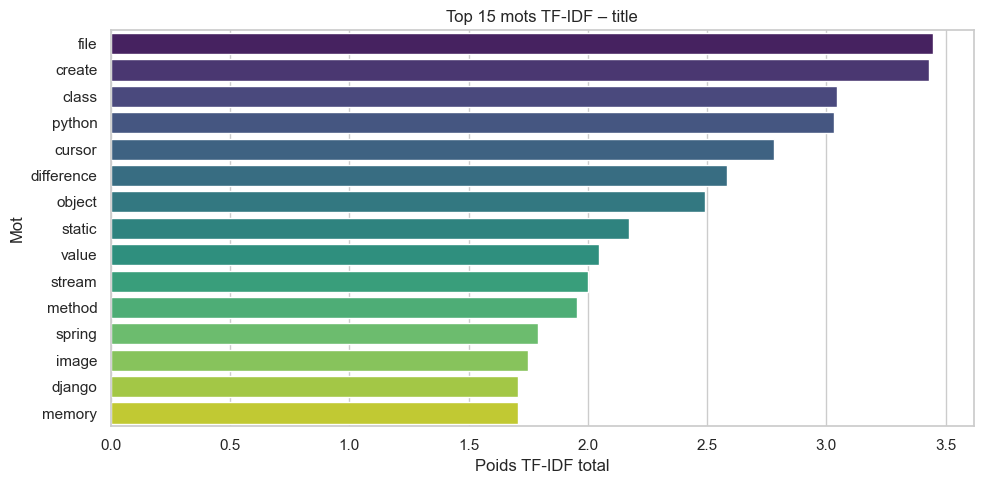

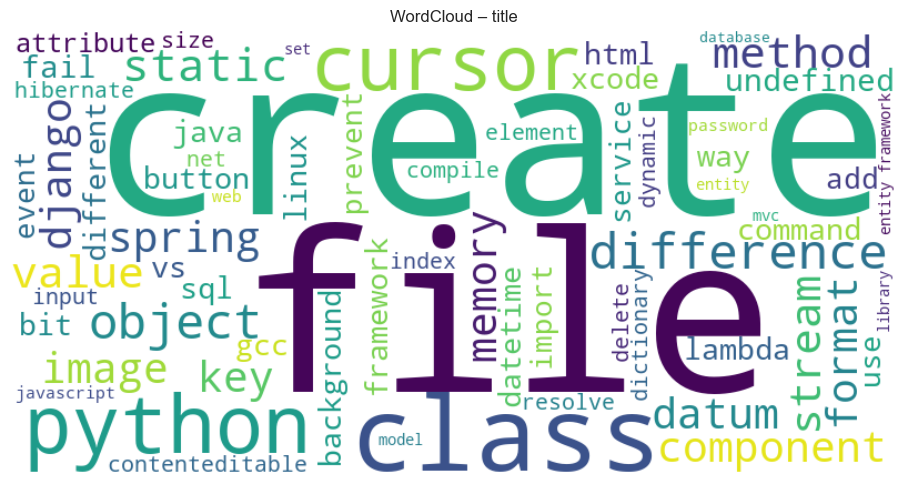

Shape de la matrice TF-IDF (body) : (91, 552)
Top 15 mots (body) par poids TF-IDF :
class: 3.89
like: 3.77
use: 3.28
image: 3.14
way: 3.12
file: 2.95
model: 2.79
time: 2.77
want: 2.63
static: 2.54
error: 2.54
need: 2.54
code: 2.52
new: 2.48
work: 2.45


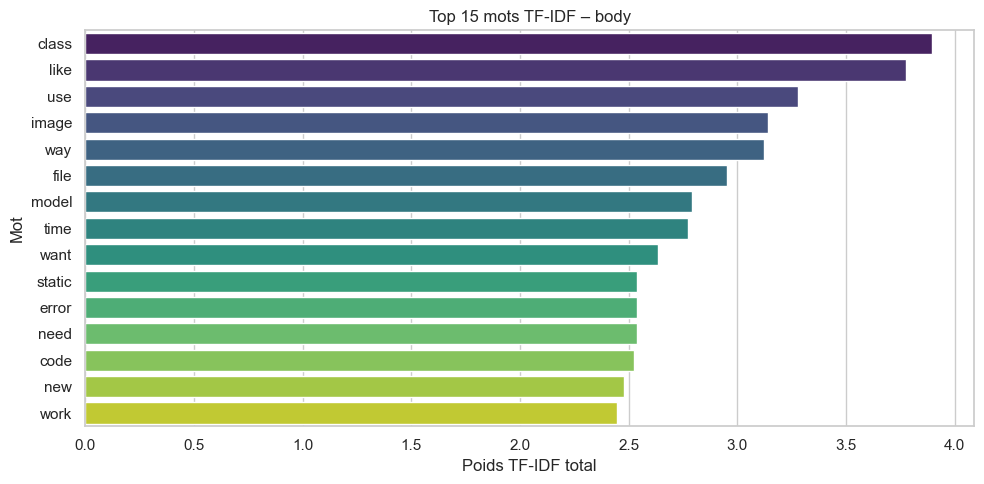

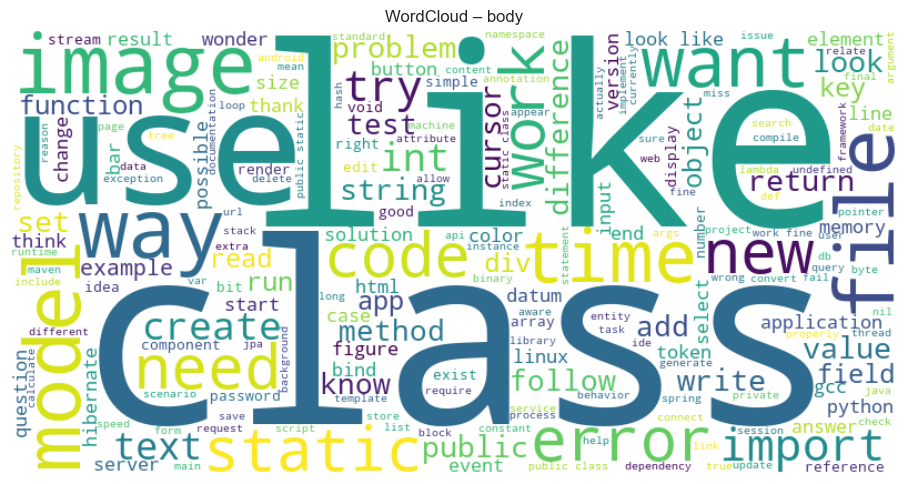

Shape de la matrice TF-IDF (title + body) : (91, 572)
Top 15 mots (title + body) par poids TF-IDF :
class: 3.91
like: 3.34
image: 3.15
file: 3.12
use: 3.12
way: 2.90
static: 2.67
model: 2.65
create: 2.59
time: 2.54
import: 2.34
new: 2.34
want: 2.26
code: 2.25
work: 2.24


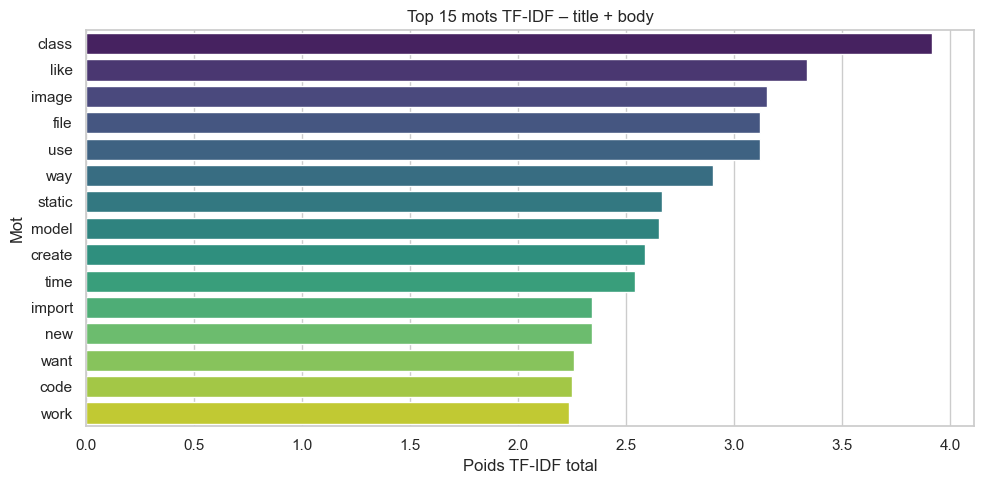

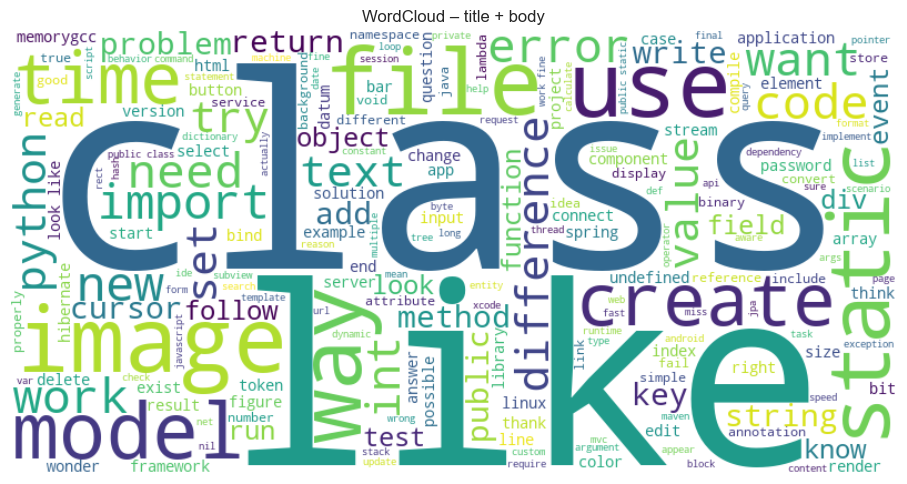

In [18]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)

# --------------------------------------
# --- VECTORISATION DES TITRES NETTOYES
# --------------------------------------
X_title_tfidf, title_vocab, top_title_words = eda.vectorize_tfidf(
    sample_explo_wo["clean_title"], label="title"
)

# --------------------------------------
# --- VECTORISATION DES CORPS NETTOYES
# --------------------------------------
X_body_tfidf, body_vocab, top_body_words = eda.vectorize_tfidf(
    sample_explo_wo["clean_body"], label="body"
)
# ----------------------------------------------
# --- VECTORISATION DE TITRES + COPRS FUSIONNES
# ----------------------------------------------
# --- ON FUSIONNE TITLE ET BODY
sample_explo_wo["clean_title_body"] = (
    sample_explo_wo["clean_title"].fillna("") + " " + sample_explo_wo["clean_body"].fillna("")
)
# --- VECTORISATION SUR clean_title_body
X_titlebody_tfidf, titlebody_vocab, top_titlebody_words = eda.vectorize_tfidf(
    sample_explo_wo["clean_title_body"],
    label="title + body"
)


#### **4.1.2. REDUCTION DE DIMENSION (SVD, PCA)**

**Objectif:**  
Visualiser ou compresser les vecteurs  

Les représentations vectorielles issues de TF-IDF sont souvent très dimensionnelles et creuses.  
Dans cette sous-section, nous appliquons des techniques de réduction de dimension telles que TruncatedSVD (adapté aux matrices creuses) ou PCA (sur matrices denses) afin de :
- Visualiser les documents dans un espace 2D ou 3D
- Réduire la complexité pour certains algorithmes
- Identifier des regroupements thématiques potentiels

Cette étape est particulièrement utile pour l’exploration visuelle ou comme prétraitement pour des modèles non supervisés.


Explained variance (title) : 7.28%


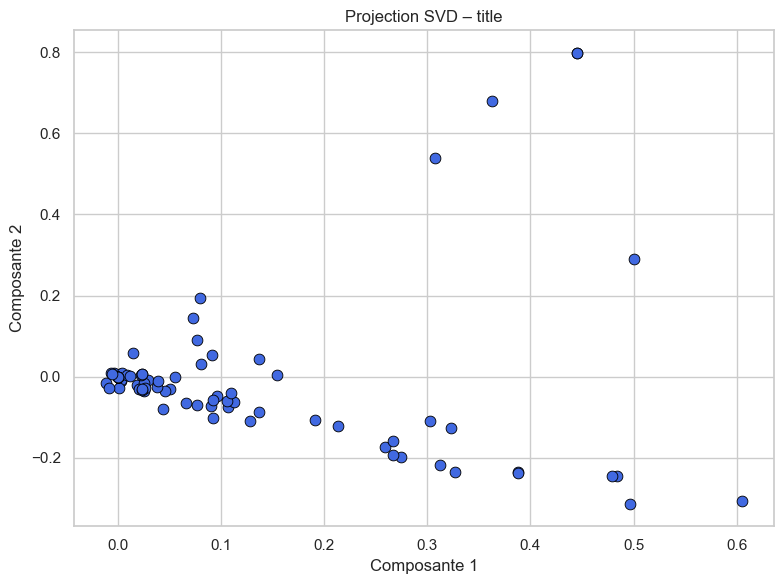

Explained variance (body) : 3.65%


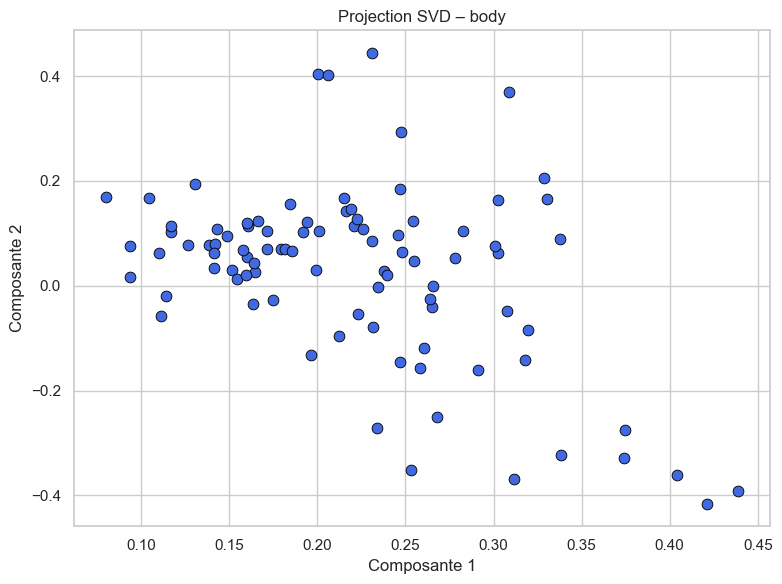

Explained variance (title + body) : 3.61%


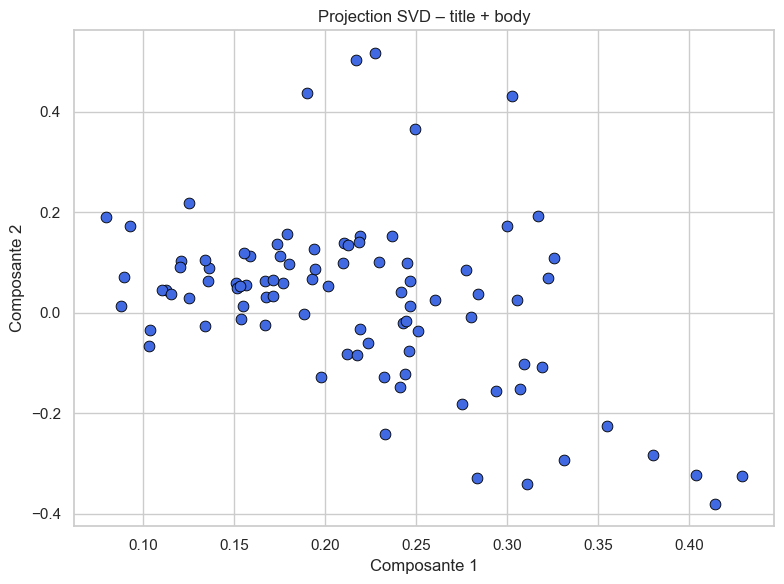

In [19]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)

# --------------------------------------
# --- REDUCTION DIMENSIONS SVD DES TITRES NETTOYES
# --------------------------------------
X_title_svd, svd_title = eda.apply_svd_and_plot(X_title_tfidf, label="title")
# --------------------------------------
# --- REDUCTION DIMENSIONS SVD DES CORPS NETTOYES
# --------------------------------------
X_body_svd, svd_body = eda.apply_svd_and_plot(X_body_tfidf, label="body")
# ----------------------------------------------
# --- REDUCTION DIMENSIONS SVD DE TITRES + COPRS FUSIONNES
# ----------------------------------------------
X_titlebody_svd, svd_titlebody = eda.apply_svd_and_plot(X_titlebody_tfidf, label="title + body")

Variance expliquée cumulée (title) :
 - 10 composantes : 33.05%
 - 20 composantes : 58.14%
 - 50 composantes : 97.61%


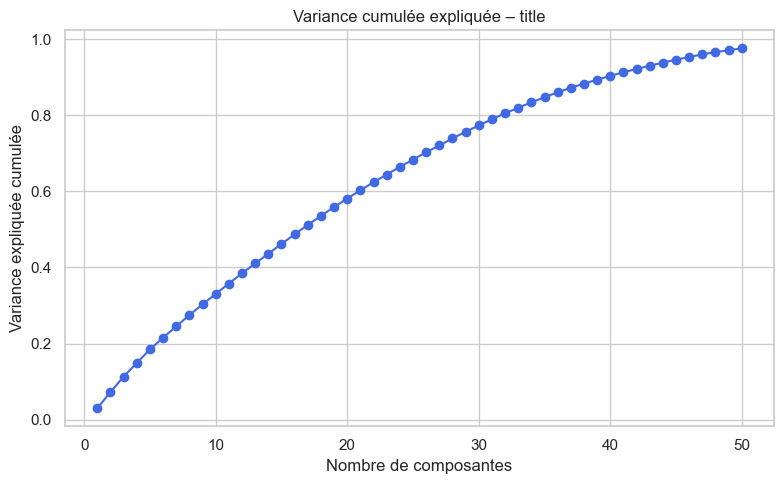

Variance expliquée cumulée (body) :
 - 10 composantes : 21.64%
 - 20 composantes : 38.72%
 - 50 composantes : 74.43%


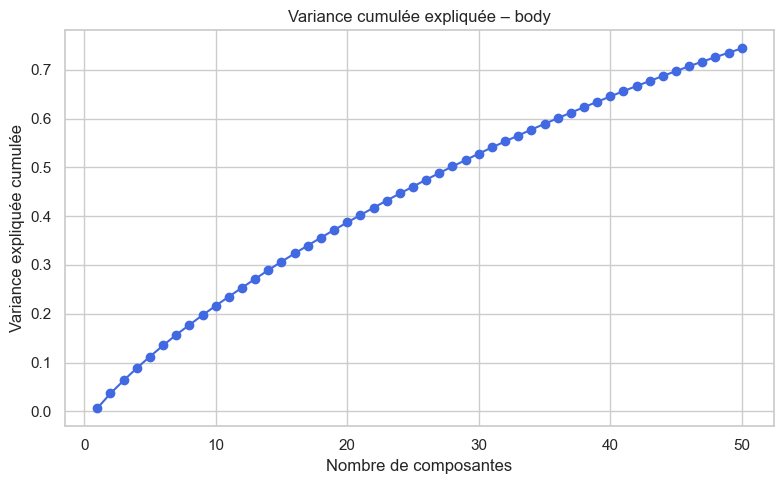

Variance expliquée cumulée (title + body) :
 - 10 composantes : 21.39%
 - 20 composantes : 38.46%
 - 50 composantes : 74.44%


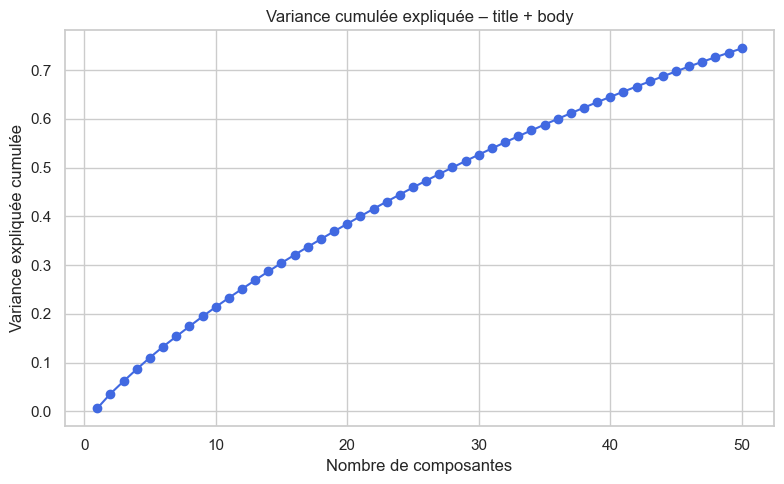

In [20]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)

# SVD avec 100 composantes
X_title_svd100, svd_title100 = eda.apply_svd_variance(X_title_tfidf, label="title", n_components=50)
X_body_svd100, svd_body100 = eda.apply_svd_variance(X_body_tfidf, label="body", n_components=50)
X_titlebody_svd100, svd_titlebody100 = eda.apply_svd_variance(X_titlebody_tfidf, label="title + body", n_components=50)


#### **4.1.3. EMBEDDINGS**

**Objectif:**  
Représentations denses et contextuelles  

Les embeddings sont des représentations vectorielles denses et continues qui capturent les relations sémantiques entre les mots.  
Contrairement à TF-IDF, qui repose sur des fréquences, les embeddings permettent de représenter le sens des mots dans leur contexte.  
Dans cette sous-section, nous explorons différentes approches d’embeddings, notamment :
- Word2Vec (basé sur la co-occurrence locale)
- GloVe (basé sur la co-occurrence globale)
- BERT ou autres modèles de type transformer (contextualisés)

Ces représentations sont particulièrement utiles pour des modèles profonds ou pour améliorer la qualité des suggestions de tags.



1. Word2Vec,  
2. BERT,  
3. etc

##### 4.1.3.1. METHODE SBERT

In [21]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)

# --- PREPARATION DES CORPUS
corpus_title = sample_explo_wo["clean_title"].fillna("").tolist()
corpus_body = sample_explo_wo["clean_body"].fillna("").tolist()
corpus_titlebody = sample_explo_wo["clean_title_body"].fillna("").tolist()
# --- ENCODAGE SBERT VIA API
embeddings_title = [get_embedding(text, model="sbert") for text in tqdm(corpus_title, desc="SBERT – title")]
embeddings_body = [get_embedding(text, model="sbert") for text in tqdm(corpus_body, desc="SBERT – body")]
embeddings_titlebody = [get_embedding(text, model="sbert") for text in tqdm(corpus_titlebody, desc="SBERT – title+body")]


SBERT – title:   0%|          | 0/91 [00:00<?, ?it/s]

SBERT – body:   0%|          | 0/91 [00:00<?, ?it/s]

SBERT – title+body:   0%|          | 0/91 [00:00<?, ?it/s]

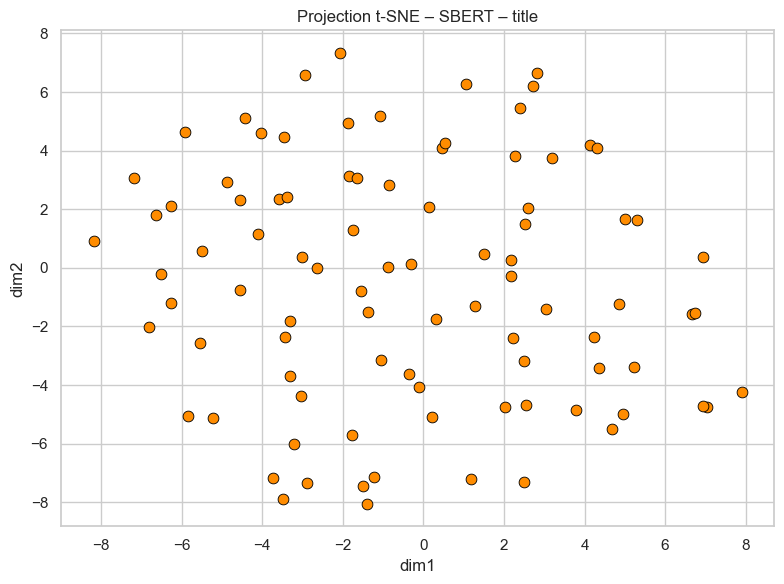

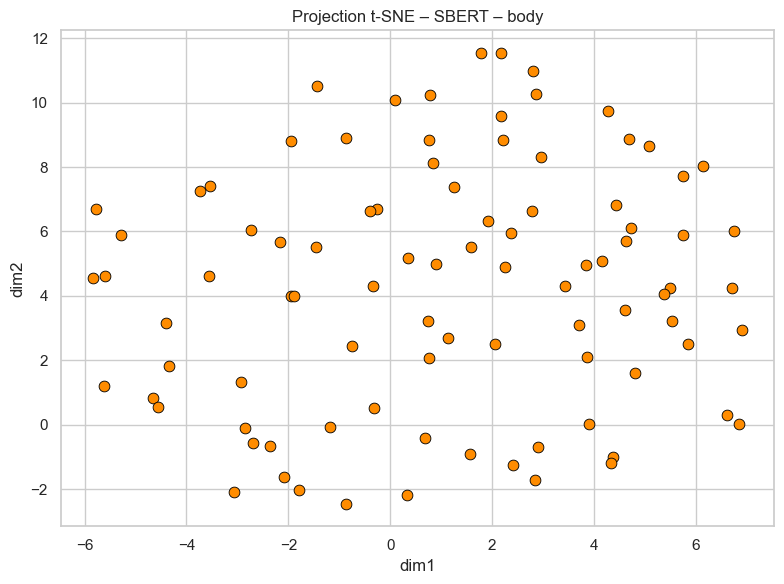

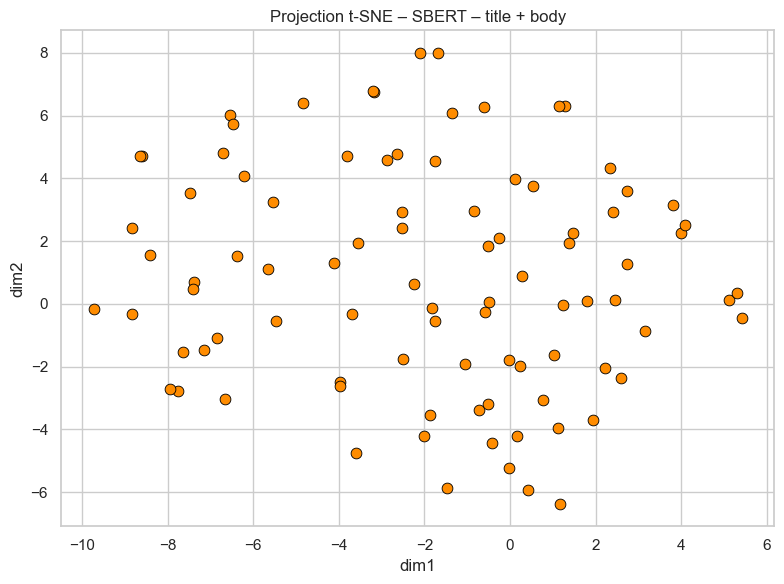

d:\machine_learning_training\openclassrooms_projects\05_categorisez_automatiquement_question\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


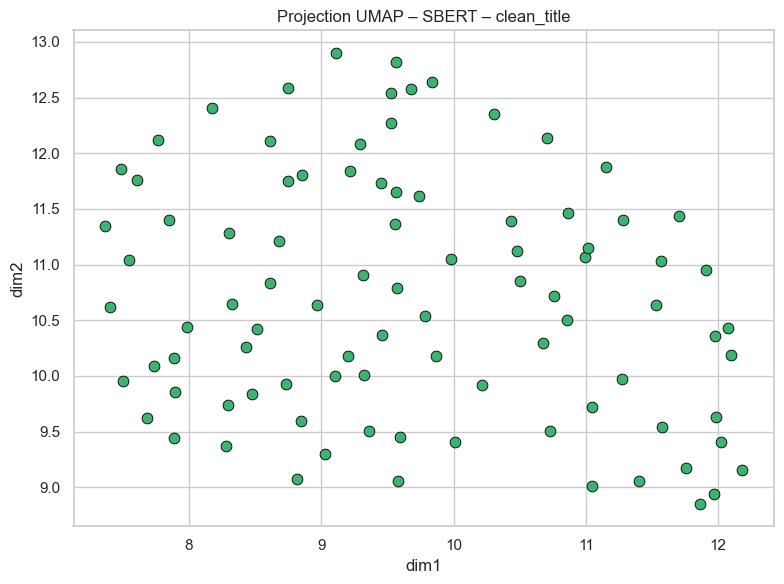

d:\machine_learning_training\openclassrooms_projects\05_categorisez_automatiquement_question\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


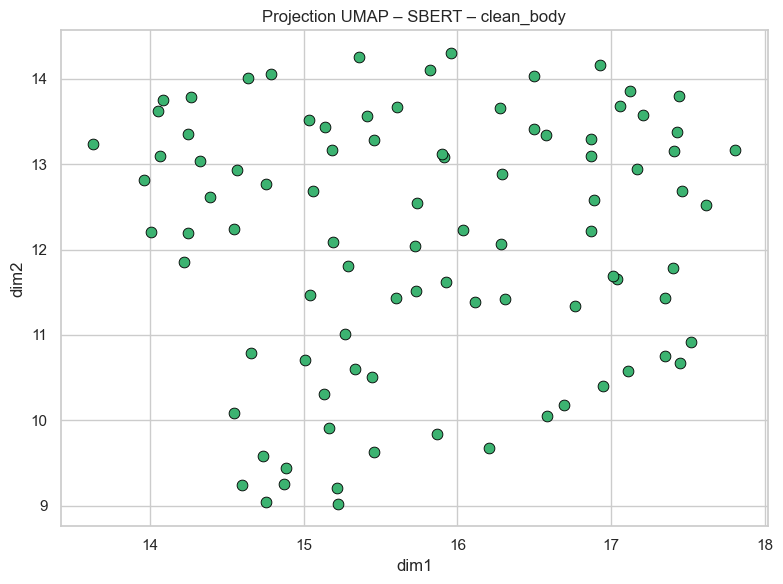

d:\machine_learning_training\openclassrooms_projects\05_categorisez_automatiquement_question\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


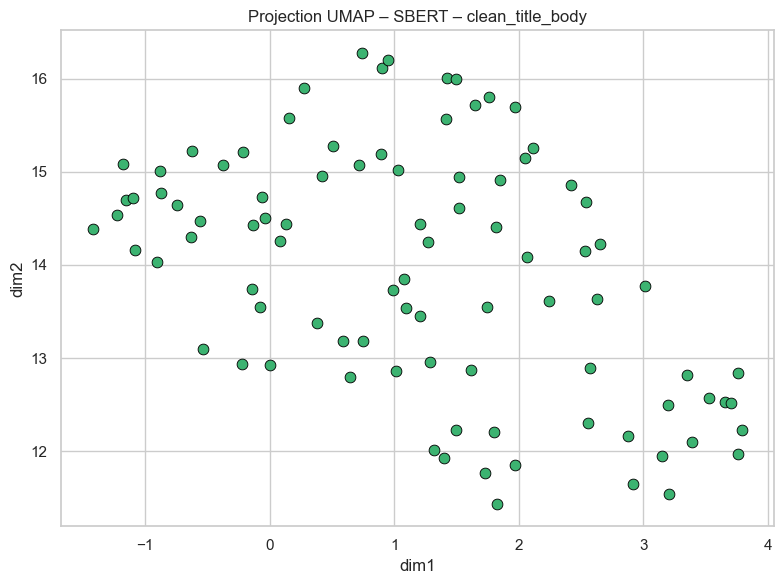

In [22]:

# --- VISUALISATION TSNE
# Conversion préalable
embeddings_title = np.array(embeddings_title)
embeddings_body = np.array(embeddings_body)
embeddings_titlebody = np.array(embeddings_titlebody)

eda.plot_tsne(embeddings_title, label="SBERT – title")
eda.plot_tsne(embeddings_body, label="SBERT – body")
eda.plot_tsne(embeddings_titlebody, label="SBERT – title + body")

# --- VISUALISATION UMAP
# clean_title
eda.plot_umap(embeddings_title, label="SBERT – clean_title")
# clean_body
eda.plot_umap(embeddings_body, label="SBERT – clean_body")
# clean_title_body
eda.plot_umap(embeddings_titlebody, label="SBERT – clean_title_body")


##### 4.1.3.2. METHODE WORD2VEC

In [23]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)

# --- CREATION DES CORPUS
corpus_title = sample_explo_wo["clean_title"].fillna("").tolist()
corpus_body = sample_explo_wo["clean_body"].fillna("").tolist()
corpus_titlebody = sample_explo_wo["clean_title_body"].fillna("").tolist()
# --- ENCODAGE WORD2VEC VIA API
# embeddings_title = [get_embedding(text, model="word2vec") for text in tqdm(corpus_title, desc="Word2Vec – title")]
# embeddings_body = [get_embedding(text, model="word2vec") for text in tqdm(corpus_body, desc="Word2Vec – body")]
# embeddings_titlebody = [get_embedding(text, model="word2vec") for text in tqdm(corpus_titlebody, desc="Word2Vec – title+body")]



# eda.plot_umap(embeddings_title, label="Word2Vec – clean_title")
# eda.plot_umap(embeddings_body, label="Word2Vec – clean_body")
# eda.plot_umap(embeddings_titlebody, label="Word2Vec – clean_title_body")


##### 4.1.3.3. METHODE UNIVERSAL SENTENCE ENCODER (USE)

In [24]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)



# --- PREPARATION DES CORPUS
corpus_title = sample_explo_wo["clean_title"].fillna("").tolist()
corpus_body = sample_explo_wo["clean_body"].fillna("").tolist()
corpus_titlebody = sample_explo_wo["clean_title_body"].fillna("").tolist()

# --- ENCODAGE USE VIA API
# embeddings_title = [get_embedding(text, model="use") for text in tqdm(corpus_title, desc="USE – title")]
# embeddings_body = [get_embedding(text, model="use") for text in tqdm(corpus_body, desc="USE – body")]
# embeddings_titlebody = [get_embedding(text, model="use") for text in tqdm(corpus_titlebody, desc="USE – title+body")]

# --- VISUALISATION UMAP
# eda.plot_umap(embeddings_title, label="USE – clean_title")
# eda.plot_umap(embeddings_body, label="USE – clean_body")
# eda.plot_umap(embeddings_titlebody, label="USE – clean_title_body")



#### **4.1.4. VECTORISATION BoW (CountVectorizer)**

Nous appliquons ici une vectorisation de type Bag-of-Words sur le texte concaténé (titre + corps) afin d’obtenir une représentation sparse de chaque question. Cette étape est fondamentale pour la modélisation non supervisée (ex: LDA) ou d’autres analyses ultérieures.

La méthode utilisée est `CountVectorizer` de `scikit-learn`, qui transforme le texte en une matrice de fréquence des tokens, avec gestion de la fréquence maximale (`max_df`) et minimale (`min_df`) pour filtrer les mots trop communs ou trop rares.

Le corpus utilisé est basé sur l’échantillon nettoyé (`sample_explo_wo`), et les deux colonnes textuelles nettoyées sont concaténées pour renforcer le signal sémantique.



In [25]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)

corpus, X_bow, vocab = eda.build_bow_matrix(
    df=sample_explo_wo,
    col_title="clean_title",
    col_body="clean_body",
    max_df=0.9,
    min_df=5,
    stop_words="english"
)

print("✅ Matrice BoW:", X_bow.shape)
print("✅ Taille du vocabulaire:", len(vocab))


✅ Matrice BoW: (91, 129)
✅ Taille du vocabulaire: 129


#### **4.1.5. ENCODAGE DES TAGS (MULTI-LABEL BINARIZER)**

**Objectif:**  
Préparer les cibles pour la classification  

Dans le cadre de notre tâche de classification multi-label, chaque question peut être associée à plusieurs tags.  
Il est donc nécessaire de transformer la liste de tags de chaque question en un format binaire exploitable par les modèles supervisés.  
Dans cette sous-section, nous utilisons un `MultiLabelBinarizer` pour encoder les tags sous forme de vecteurs 0/1, où chaque colonne représente un tag unique.  
Ce format permettra d’entraîner des modèles capables de prédire plusieurs tags simultanément pour une même question.


# --- ON AFFICHE LES TAGS ENCODES


,.net,.net-4.0,64-bit,addsubview,ado.net-entity-data-model,algorithm,android,angularjs,anonymous-class,arbitrary-precision,...,web-services,webrtc,wget,where-clause,windows,wpf,xcode,xcode5,xcode6,zeus
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
87,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
88,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
89,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# --- ON AFFICHE LA FUSION DES TAGS ENCODES AVEC LE DATAFRAME sample_explo_wo : 


,PostId,Title,Body,Score,ViewCount,AnswerCount,CreationDate,TagCount,Tags,clean_title,...,web-services,webrtc,wget,where-clause,windows,wpf,xcode,xcode5,xcode6,zeus
0,18908639,Why are Haskell Maps implemented as balanced b...,"<p>From my limited knowledge of Haskell, it se...",21,2798,4,2013-09-20 04:06:07,5,"[algorithm, haskell, hashtable, binary-search-...",haskell maps implement balanced binary tree in...,...,0,0,0,0,0,0,0,0,0,0
1,3735748,Measuring the average thickness of traces in a...,<p>Here's the problem: I have a number of bina...,19,6026,7,2010-09-17 13:33:43,5,"[language-agnostic, algorithm, image, image-pr...",measure average thickness trace image,...,0,0,0,0,0,0,0,0,0,0
2,4000062,Can we create an object of an interface?,"<pre class=""lang-java prettyprint-override""><c...",33,46647,6,2010-10-22 19:01:14,5,"[java, oop, interface, instance, anonymous-class]",create object interface,...,0,0,0,0,0,0,0,0,0,0
3,22787209,How to have clusters of stacked bars,<p>So here is how my data set looks like :</p>...,90,90737,10,2014-04-01 13:22:11,5,"[python, matplotlib, seaborn, stacked-bar-char...",cluster stack bar,...,0,0,0,0,0,0,0,0,0,0
4,27349612,How Do I add Pins (Annotations) with Xcode 6 (...,"<p>I'm new to the swift language, and haven't ...",16,29467,2,2014-12-07 22:53:47,5,"[maps, xcode, ios, swift, xcode6]",add pins annotations xcode swift,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,7062605,Grails get Session and Management in Service c...,<p>I have a problem with Grails Session. I was...,17,27483,4,2011-08-15 07:36:34,5,"[service, session, grails, nullpointerexceptio...",grail session management service class,...,0,0,0,0,0,0,0,0,0,0
87,1001825,How to identify if a Lucene.Net Index exists i...,<p>I am using Lucene.Net for indexing and sear...,21,8442,6,2009-06-16 14:23:10,5,"[indexing, search, lucene.net, full-text-searc...",identify lucene net index exist folder,...,0,0,0,0,0,0,0,0,0,0
88,20959331,Cursor not showing up in UITextView,<p>Can anyone think of a reason that the blink...,77,38471,11,2014-01-06 21:10:03,5,"[iphone, uitextfield, uitextview, ipad, ios]",cursor show uitextview,...,0,0,0,0,0,0,0,0,0,0
89,11787759,How to properly format currency on ios,<p>I'm looking for a way to format a string in...,36,49649,8,2012-08-03 00:37:56,5,"[iphone, numbers, currency, formatter, ios]",properly format currency io,...,0,0,0,0,0,0,0,0,0,0


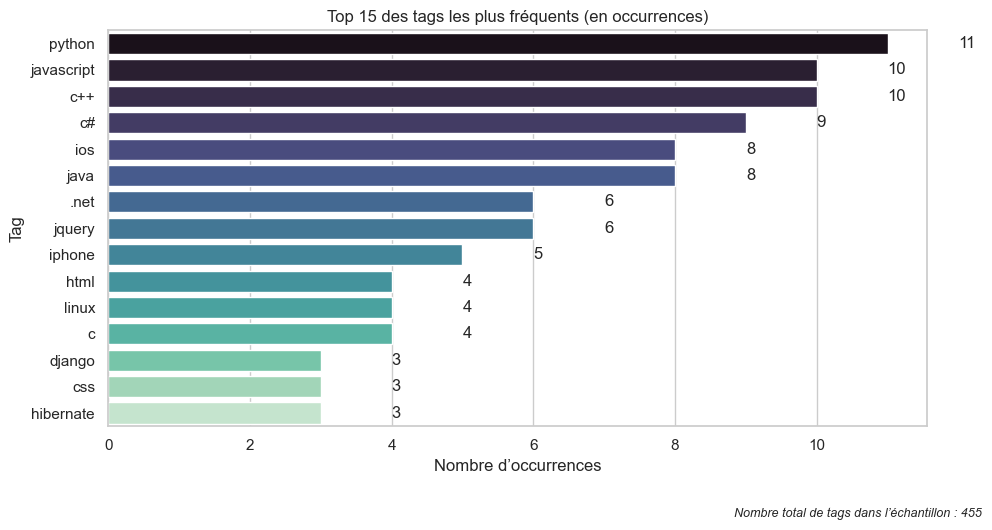

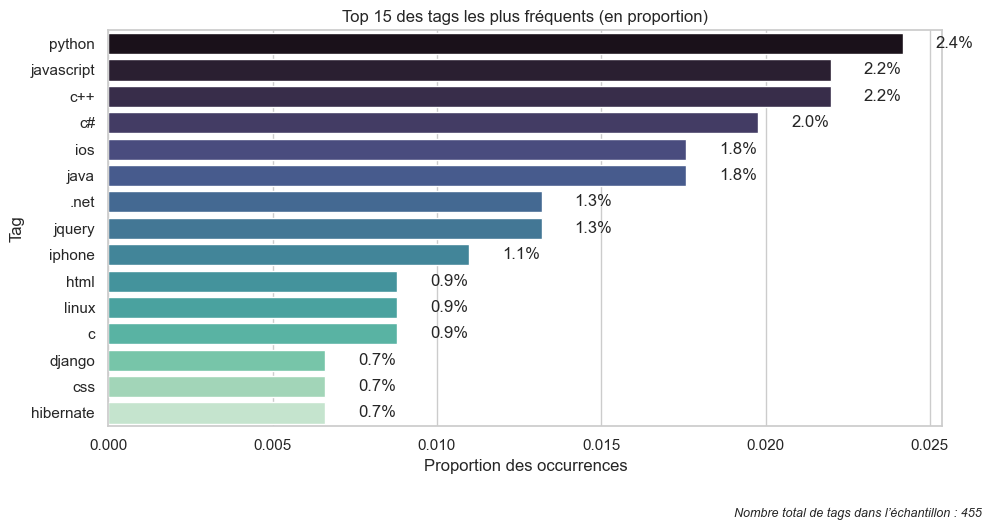

In [26]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)

# ------------------------------------------------------
# --- VERIFICATION ET CONVERSION DES TAGS SI NECESSAIRE
# ------------------------------------------------------
if isinstance(sample_explo_wo["Tags"].iloc[0], str):
    sample_explo_wo["Tags"] = sample_explo_wo["Tags"].apply(ast.literal_eval)
# -------------------------
# --- ENCODAGE MULTI-LABEL
# -------------------------
mlb = MultiLabelBinarizer()
tags_encoded = mlb.fit_transform(sample_explo_wo["Tags"])
# ---------------------------------
# --- CREATION DU DATAFRAME ENCODE
# ----------------------------------
tags_df = pd.DataFrame(tags_encoded, columns=mlb.classes_)
print("# --- ON AFFICHE LES TAGS ENCODES")
display(tags_df)
# --------------------------------------------
# --- FUSION AVEC LE DATAFRAME sample_explo_wo
# ---------------------------------------------
sample_explo_wo = pd.concat([sample_explo_wo, tags_df], axis=1)
print("# --- ON AFFICHE LA FUSION DES TAGS ENCODES AVEC LE DATAFRAME sample_explo_wo : ")
display(sample_explo_wo)
# ----------------------------
# --- SAUVEGARDE DU BINARIZER
# -----------------------------
# Crée le dossier à la racine si besoin
os.makedirs("../models", exist_ok=True)
joblib.dump(mlb, "../models/multilabel_binarizer.pkl")

# --- VISUALISATION 
tag_counts = tags_df.sum().sort_values(ascending=False)
tag_freq_df = tag_counts.reset_index()
tag_freq_df.columns = ["Tag", "Count"]
eda.plot_tag_occurrences(tag_freq_df, top_n=15, palette="mako")
eda.plot_tag_distribution(tag_freq_df, top_n=15, palette="mako")


## EXPORT

Les artefacts `corpus`, `X_bow` et `vocab` ayant été créés dans la section précédente dédiée à la vectorisation Bag-of-Words, ils sont ici uniquement exportés pour être utilisés dans le notebook `3_modele_non_supervise_lda.ipynb` (modélisation LDA).

Aucun recalcul n’est effectué ici afin de garantir la modularité du pipeline.


In [ ]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)

# ---------------------------------
# --- CREATION DU DOSSIER D'EXPORT
# ---------------------------------
os.makedirs("../data/processed", exist_ok=True)
# ---------------------------------
# --- EXPORT DU CORPUS AVEC PostId
# ---------------------------------
df_export = sample_explo_wo[["PostId"]].copy()
df_export["text_combined"] = corpus
df_export.to_csv("../data/processed/corpus_for_lda.csv", index=False)
# -----------------------------------------------
# --- EXPORT DE LA MATRICE BoW ET DU VOCABULAIRE
# -----------------------------------------------
joblib.dump(X_bow, "../data/processed/corpus_for_lda_bow.pkl")
joblib.dump(vocab, "../data/processed/corpus_for_lda_vocab.pkl")

# ------------------
# --- VERIFICATIONS
# ------------------
df_corpus = pd.read_csv("../data/processed/corpus_for_lda.csv")
print("# --- corpus_for_lda.csv →", df_corpus.shape)
df_corpus.head()

X_bow = joblib.load("../data/processed/corpus_for_lda_bow.pkl")
print("# --- MATRICE BoW → SHAPE:", X_bow.shape)

vocab = joblib.load("../data/processed/corpus_for_lda_vocab.pkl")
print("# --- TAILLE DU VOCABULAIRE :", len(vocab))
print("# --- EXEMPLES DE MOTS :", vocab[:5])


📄 corpus_for_lda.csv → (91, 2)
🔢 Matrice BoW → shape: (91, 499)
📚 Taille du vocabulaire : 499
🔠 Exemples de mots : ['able', 'accept', 'access', 'accomplish', 'act']


## 5. MODÉLISATION

Après avoir nettoyé, exploré et vectorisé les données textuelles, cette section vise à appliquer des techniques de modélisation pour extraire de l'information ou prédire les tags associés aux questions Stack Overflow.

Nous distinguons deux approches complémentaires :

- **Modélisation non supervisée** : pour explorer les thématiques latentes du corpus sans utiliser les tags
- **Modélisation supervisée** : pour entraîner un modèle capable de prédire automatiquement les tags à partir du texte

Chaque approche sera testée sur les représentations vectorielles construites précédemment (TF-IDF, embeddings), et évaluée selon des critères adaptés à la tâche.

⚠️ Cette section ne sera pas exécutée dans ce notebook.  
Elle sert uniquement de repère pour structurer le projet.  
Les modélisations seront réalisées dans deux notebooks séparés :
- `2_modelisation_non_supervisee.ipynb`
- `3_modelisation_supervisee.ipynb`



### 5.1. MODÉLISATION NON SUPERVISÉE

La modélisation non supervisée permet d’explorer les structures cachées du corpus sans utiliser les tags comme variable cible.  
Dans cette sous-section, nous appliquons des techniques telles que :

- **LDA (Latent Dirichlet Allocation)** pour identifier des thématiques latentes dans les questions
- **Clustering (KMeans, DBSCAN, etc.)** pour regrouper les questions selon leur similarité sémantique

Ces méthodes peuvent révéler des regroupements thématiques, aider à la navigation dans le corpus, ou enrichir les suggestions de tags.


### 5.2. MODÉLISATION SUPERVISÉE

La modélisation supervisée vise à prédire automatiquement les tags associés à une question à partir de son texte.  
Il s’agit d’un problème de **classification multi-label**, où chaque observation (question) peut être associée à plusieurs classes (tags).

Dans cette sous-section, nous testons plusieurs modèles adaptés à cette tâche, tels que :

- **Logistic Regression** avec stratégie One-vs-Rest
- **Random Forest**, **SVM**, ou **XGBoost**
- **Réseaux de neurones** (optionnel)

Les performances seront évaluées à l’aide de métriques spécifiques au multi-label (F1-score, précision, rappel, etc.).


## ANNEXE 

### A.1. Nomenclature des DataFrames utilisés

| Nom du DataFrame       | Description |
|------------------------|-------------|
| `brut_df`              | Données brutes chargées depuis le fichier CSV |
| `sample_df`            | Échantillon de 100 questions tiré de `brut_df` |
| `sample_clean`         | Version nettoyée de `sample_df` (après prétraitement) |
| `sample_explo`         | Copie de travail pour l’exploration (à partir de `sample_clean`) |
| `sample_explo_wo`      | Version de `sample_explo` sans outliers (`wo = without outliers`) |
| `sample_outliers`      | Sous-ensemble de `sample_explo` contenant uniquement les outliers |
| `full_clean`           | Données complètes nettoyées (lors de la mise à l’échelle) |
| `full_explo`           | Copie de travail pour l’exploration complète |
| `full_explo_wo`        | Version sans outliers du corpus complet |


### A.2. RAPPELS DES NOTIONS IMPLIQUEES DANS LE FEATURE ENGINEERING EN NLP

Cette annexe vise à expliciter les concepts mathématiques et vectoriels sous-jacents aux principales étapes de transformation des textes dans le cadre du NLP. Elle s’adresse à un lecteur ayant une formation scientifique avancée.



#### A.2.1. Vecteurs creux vs. vecteurs denses

- Un **vecteur creux** (sparse vector) est un vecteur dont la majorité des composantes sont nulles.
  - Exemple : `[0, 0, 0.5, 0, 0, 0.3, 0, 0, 0, 0.2]`
  - Typique des représentations TF-IDF : chaque document n’utilise qu’un petit sous-ensemble du vocabulaire.

- Un **vecteur dense** est un vecteur dont la plupart des composantes sont non nulles.
  - Exemple : `[0.12, -0.03, 0.45, 0.08, -0.22, 0.19]`
  - Typique des embeddings ou des vecteurs après réduction de dimension.



#### A.2.2. Variables latentes et espace latent

- Une **variable latente** est une variable non observée directement, mais déduite à partir des données.
- En NLP, les **axes latents** correspondent à des thématiques ou structures cachées dans les textes.
- L’**espace latent** est un espace vectoriel réduit, où chaque dimension représente une composante thématique implicite.



#### A.2.3. Base canonique vs. base sémantique

- La **base canonique** est formée par les mots du vocabulaire : chaque mot est une dimension orthogonale.
- Elle est arbitraire, très grande, et souvent redondante.
- Une **base sémantique** est une base apprise ou extraite (via SVD ou embeddings) où chaque dimension reflète un thème ou une proximité de sens.
- Elle est plus compacte, plus informative, mais non orthogonale.



#### A.2.4. Décomposition SVD (Singular Value Decomposition)  

Soit une matrice TF-IDF X de taille (m × n), où :

- m est le nombre de documents
- n est la taille du vocabulaire (nombre de mots uniques)
- Chaque ligne de X est un vecteur TF-IDF représentant un document

La décomposition en valeurs singulières (SVD) permet d’écrire :

X = U × Σ × Vᵗ

avec :

- U ∈ ℝ^(m × r) : matrice des vecteurs propres des documents (orthogonaux)
- Σ ∈ ℝ^(r × r) : matrice diagonale contenant les valeurs singulières décroissantes
- V ∈ ℝ^(n × r) : matrice des vecteurs propres des mots (orthogonaux)

où r est le rang de X (r ≤ min(m, n))


**Réduction de dimension**

En pratique, on ne conserve que les k premières composantes (avec k ≪ r), ce qui donne une approximation de rang k :

X ≈ U_k × Σ_k × V_kᵗ

avec :

- U_k ∈ ℝ^(m × k) : projection des documents dans un espace latent de dimension k
- Σ_k ∈ ℝ^(k × k) : valeurs singulières principales
- V_k ∈ ℝ^(n × k) : projection des mots dans le même espace latent


**Interprétation**

- Chaque document est représenté par un vecteur dense de dimension k, capturant ses composantes thématiques latentes
- Chaque mot est également projeté dans cet espace, révélant ses affinités sémantiques
- Les valeurs singulières indiquent l’importance relative de chaque axe latent

**Utilité en NLP**

- Réduction de dimension : compresser les vecteurs TF-IDF très grands et creux
- Suppression du bruit lexical : éliminer les dimensions peu informatives
- Découverte de thématiques : chaque axe latent peut être interprété comme un thème sémantique

Cette technique est à la base de la méthode LSA (Latent Semantic Analysis).

#### A.2.5. Embeddings (Word2Vec, FastText, BERT…)

- Les **embeddings** sont des vecteurs denses appris par des modèles de langage.
- Ils sont construits pour que les mots ayant des contextes similaires aient des vecteurs proches.
- Contrairement à TF-IDF, ils capturent :
  - La **sémantique** (proximité de sens)
  - Le **contexte** (dans les modèles comme BERT)
  - Les **relations syntaxiques** et **logiques**

Exemple d’analogie vectorielle :  
`king - man + woman ≈ queen`

Mathématiquement, les embeddings sont issus d’une **factorisation implicite** de la matrice de co-occurrence des mots, ou d’un apprentissage supervisé/non supervisé sur des tâches de prédiction de contexte.



#### A.2.6. Encodage des tags – MultiLabelBinarizer

- Les tags sont des cibles multi-label (un document peut avoir plusieurs étiquettes).
- Le **MultiLabelBinarizer** transforme chaque liste de tags en un vecteur binaire.

Exemple :

| Tags | Encodage |
|------|----------|
| ['python', 'django'] | [1, 0, 1, 0, …] |

Chaque dimension correspond à un tag unique.  
Ce format est requis pour entraîner un modèle de classification multi-label.



#### A.2.7. Résumé global du pipeline vectoriel

| Étape | Entrée | Sortie | Objectif |
|-------|--------|--------|----------|
| TF-IDF | Texte brut | Vecteurs creux | Pondérer les mots |
| SVD / PCA | TF-IDF | Vecteurs denses réduits | Capturer les axes thématiques |
| Embeddings | Texte brut | Vecteurs denses sémantiques | Capturer le sens |
| MultiLabelBinarizer | Tags | Vecteurs binaires (cibles) | Préparer les cibles |

---


### A.3. FONCTIONNEMENT DE FASTAPI

```text
+-------------------------------+
|        Client (UI,           |
|   script Python, Swagger)    |
+---------------+---------------+
                |
                |  POST /embed/sbert
                |  { "text": "..." }
                v
+---------------+---------------+
|         FastAPI App           |
|     (src/api/main.py)         |
+---------------+---------------+
                |
                v
+---------------+---------------+
|  Route /embed/sbert           |
|  (embed_routes.py)            |
|  - Valide l'entrée (pydantic) |
|  - Appelle encode_with_sbert  |
+---------------+---------------+
                |
                v
+---------------+---------------+
|  SBERT Model (sbert_model.py) |
+---------------+---------------+
                |
                v
+---------------+---------------+
|  Embedding vector (list)      |
|  ex: [0.123, -0.456, ...]     |
+---------------+---------------+
                |
                v
+-------------------------------+
|   JSON Response to Client     |
|   { "embedding": [...] }      |
+-------------------------------+
